In [2]:
from itertools import combinations, permutations, product
from typing import Dict, Tuple, List, Any, NamedTuple, Callable

import jax
# If you want to perform simulations in float64 you have to call this before any JAX compuation
# jax.config.update('jax_enable_x64', True)

import jax
import jax.numpy as jnp
from jax import Array
import os

os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
from jax import jit
import jax.numpy as jnp
import ase.calculators.calculator as ase_calc
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
)  # prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc


def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


read_parameter_card = """
read parameter card
* methanol
*
NONBONDED
CG321    0.0       {CG321EP:.4f}     {CG321RM:.4f}   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       {CLGA1EP:.4f}    {CLGA1RM:.4f} ! CLET, DCLE, chloroethane, 1,1-dichloroethane
HGA2     0.0       {HGA2EP:.4f}    {HGA2RM:.4f} ! alkane, yin and mackerell, 4/98
END
"""
# HGA2     0.0       -0.0200     1.3400 ! alkane, yin and mackerell, 4/98


NATOMS = 10

model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)


import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm


import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view


from scipy.optimize import minimize

ev2kcalmol = 1 / (ase.units.kcal / ase.units.mol)

CG321EP = -0.0560
CG321RM = 2.0100
CLGA1EP = -0.3430
CLGA1RM = 1.9100
HGA2EP =  -0.0200  
HGA2RM = 1.3400 

def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)


def capture_neighbour_list():
    # Print something
    distance_command = """
    open unit 1 write form name total.dmat
    
    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
    
    close unit 1"""
    _ = pycharmm.lingo.charmm_script(distance_command)

    with open("total.dmat") as f:
        output_dmat = f.read()

    atom_number_type_dict = {}
    atom_number_resid_dict = {}

    pair_distance_dict = {}
    pair_resid_dict = {}

    for _ in output_dmat.split("\n"):
        if _.startswith("*** "):
            _, n, resid, resname, at, _ = _.split()

            n = int(n.split("=")[0]) - 1
            atom_number_type_dict[n] = at
            atom_number_resid_dict[n] = int(resid) - 1

    for _ in output_dmat.split("\n"):
        if _.startswith("  "):
            a, b, dist = _.split()
            a = int(a) - 1
            b = int(b) - 1
            dist = float(dist)
            if atom_number_resid_dict[a] < atom_number_resid_dict[b]:
                pair_distance_dict[(a, b)] = dist
                pair_resid_dict[(a, b)] = (
                    atom_number_resid_dict[a],
                    atom_number_resid_dict[b],
                )

    return {
        "atom_number_type_dict": atom_number_type_dict,
        "atom_number_resid_dict": atom_number_resid_dict,
        "pair_distance_dict": pair_distance_dict,
        "pair_resid_dict": pair_resid_dict,
    }


def get_forces_pycharmm():
    positions = coor.get_positions()
    force_command = """coor force sele all end"""
    _ = pycharmm.lingo.charmm_script(force_command)
    forces = coor.get_positions()
    coor.set_positions(positions)
    return forces


def view_atoms(atoms):
    return view(atoms, viewer="x3d")


from itertools import combinations


def dimer_permutations(n_mol):
    dimer_permutations = list(combinations(range(n_mol), 2))
    return dimer_permutations


def calc_pycharmm_dimers(n_mol=20, n_atoms=5, forces=False):
    RANGE = len(dimer_permutations(n_mol))

    ele_energies = np.zeros(RANGE)
    evdw_energies = np.zeros(RANGE)
    mm_forces = np.zeros((RANGE, n_atoms * n_mol, 3))

    for i, (a, b) in enumerate(dimer_permutations(20)):
        reset_block_no_internal()
        a += 1
        b += 1
        block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
        """
        _ = pycharmm.lingo.charmm_script(block)
        # print(_)
        energy.show()
        if forces:
            f = get_forces_pycharmm().to_numpy()
            mm_forces[i] = f

        evdw = energy.get_vdw()
        evdw_energies[i] = evdw
        e = energy.get_elec()
        ele_energies[i] = e

    return {
        "ele_energies": ele_energies,
        "evdw_energies": evdw_energies,
        "mm_forces": mm_forces,
    }


def reset_block():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


def reset_block_no_internal():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


reset_block_no_internal()


import MDAnalysis as mda


def load_pdb_data(pdb_file):
    # loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
    # loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)
    
    atypes = psf.get_atype()
    atc = pycharmm.param.get_atc()
    residues = psf.get_res()
    psf.get_natom()
    # nl_info = capture_neighbour_list()

    # TODO: this assumes a pure system, need to update
    atoms_per_res = int(len(atypes) / len(residues))
    n_res = len(residues)
    resids = np.array([[i] * atoms_per_res for i in range(n_res)]).flatten()
    u = mda.Universe(pdb_file)
    atom_names = [s for s in list(u.atoms.names)]
    atom_positions = list(u.atoms.positions)
    atomic_numbers = np.array(
        [ase.data.atomic_numbers[parse_non_int(s)] for s in atom_names]
    )
    mda_resids = [s for s in list(u.atoms.resids)]
    mda_res_at_dict = {
        (a - 1, b): i for i, (a, b) in enumerate(zip(mda_resids, atom_names))
    }
    charmm_res_at_dict = {(a, b): i for i, (a, b) in enumerate(zip(resids, atypes))}
    an_charmm_res_at_dict = {v: k for k, v in charmm_res_at_dict.items()}
    an_mda_res_at_dict = {v: k for k, v in mda_res_at_dict.items()}
    atom_positions = np.array(atom_positions)
    reorder = np.array(
        [charmm_res_at_dict[an_mda_res_at_dict[i]] for i in range(len(atom_positions))]
    )
    atom_positions = atom_positions[reorder]
    atomic_numbers = atomic_numbers[reorder]

    return {
        "atom_names": atom_names,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
        "mda_resids": mda_resids,
        "mda_res_at_dict": mda_res_at_dict,
        "charmm_res_at_dict": charmm_res_at_dict,
        "an_charmm_res_at_dict": an_charmm_res_at_dict,
        "an_mda_res_at_dict": an_mda_res_at_dict,
        "atom_positions": atom_positions,
        "reorder": reorder,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
    }


def get_data_mda(fn):
    pdb_file = data_path / "dcmk" / fn
    pdb_data_mda = load_pdb_data(pdb_file)
    return pdb_data_mda


epsilon = 10 ** (-6)
from e3x.nn import smooth_switch, smooth_cutoff


def combine_with_sigmoid(
    r,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=5.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)

    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy

    mm_contrib = charmm_on_scale * mm_energy
    mm_contrib = mm_contrib * charmm_off_scale

    return mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale


def indices_of_pairs(a, b, n_atoms=5, n_mol=20):
    assert a < b, "by convention, res a must have a smaller index than res b"
    assert a >= 1, "res indices can't start from 1"
    assert b >= 1, "res indices can't start from 1"
    assert a != b, "pairs can't contain same residue"
    return np.concatenate(
        [
            np.arange(0, n_atoms, 1) + (a - 1) * n_atoms,
            np.arange(0, n_atoms, 1) + (b - 1) * n_atoms,
        ]
    )


def indices_of_monomer(a, n_atoms=5, n_mol=20):
    assert a < (n_mol + 1), "monomer index outside total n molecules"
    return np.arange(0, n_atoms, 1) + (a - 1) * n_atoms


def calc_physnet_via_idx_list(all_coordinates, all_idxs, calculator):
    RANGE = len(all_idxs)
    ml_energies = np.zeros(RANGE)
    ml_forces = np.zeros((RANGE, len(all_idxs[0]), 3))

    for i, idxs in enumerate(all_idxs):
        # set positions
        calculator.set_positions(all_coordinates[idxs])

        ml_energies[i] = calculator.get_potential_energy()
        ml_forces[i] = calculator.get_forces()

    return {"ml_energies": ml_energies, "ml_forces": ml_forces}


def get_dimer_distances(dimer_idxs, all_monomer_idxs, R):
    out_dists = np.zeros(len(dimer_idxs))
    for i, (a, b) in enumerate(dimer_idxs):
        a = all_monomer_idxs[a][0]  # just distance to first atom in the molecule...
        b = all_monomer_idxs[b][0]  # TODO: generalize...
        out_dists[i] = np.linalg.norm(R[a] - R[b])

    return out_dists


def setup_ase_atoms(atomic_numbers, positions, n_atoms):
    """Create and setup ASE Atoms object with centered positions"""
    Z = [_ for i, _ in enumerate(atomic_numbers) if i < n_atoms]
    R = np.array([_ for i, _ in enumerate(positions) if i < n_atoms])
    atoms = ase.Atoms(Z, R)
    # translate to center of mass
    # atoms.set_positions(R - R.T.mean(axis=1))
    return atoms


def create_physnet_calculator(params, model, atoms, ev2kcalmol):
    """Create PhysNet calculator with specified parameters"""
    calc = get_ase_calc(
        params,
        model,
        atoms,
        conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol},
    )
    atoms.calc = calc
    return atoms


def initialize_models(restart_path, N_ATOMS_MONOMER):
    """Initialize monomer and dimer models from restart"""
    restart = get_last(restart_path)

    # Setup monomer model
    params, monomer_model = get_params_model(restart)
    monomer_model.natoms = N_ATOMS_MONOMER

    # Setup dimer model
    params, dimer_model = get_params_model(restart)
    dimer_model.natoms = N_ATOMS_MONOMER * 2

    return params, monomer_model, dimer_model


def get_rmse_mae(energy, ref_energy):
    rmse = np.sqrt(np.mean((energy - ref_energy) ** 2))
    mae = np.mean(np.abs(energy - ref_energy))
    return rmse, mae


def print_energy_comparison(mmml_energy, charmm, ref_energy):
    """Print comparison of energies with reference data"""

    print("comb")
    print(mmml_energy, ref_energy, abs(mmml_energy - ref_energy))

    print("charmm")
    print(charmm, ref_energy, abs(charmm - ref_energy))


def calculate_E_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM energies"""
    summed_ml_intE = dimer_results["ml_energies"] - monomer_results["ml_energies"][
        np.array(dimer_idxs)
    ].sum(axis=1)
    summed_mm_intE = result["ele_energies"] + result["evdw_energies"]
    return summed_ml_intE, summed_mm_intE

def calculate_F_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM forces"""
    mono = monomer_results["ml_forces"][
        np.array(dimer_idxs)
    ]
    print(mono.shape)
    a,b,c,d = mono.shape
    mono = mono.reshape(a, b*c, d)
    summed_ml_intF = dimer_results["ml_forces"] - mono
    summed_mm_intF = result["mm_forces"]
    return summed_ml_intF, summed_mm_intF

def get_fnkey(fn):
    fnkey = str(fn).split("/")[-1].split(".")[0].upper()
    fnkey = "_".join(fnkey.split("_")[:3])
    return fnkey

def calc_energies_forces(
    fn, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    pdb_data_mda = get_data_mda(fn)
    atomic_numbers, atom_positions = (
        pdb_data_mda["atomic_numbers"],
        pdb_data_mda["atom_positions"],
    )
    set_pycharmm_xyz(atom_positions)
    energy.show()

    ase_atom_full_system = ase.Atoms(atomic_numbers, atom_positions)
    
    result = None
    summed_2body = None
    mmml_energy = None
    charmm = None

    if DO_MM:
        # Calculate CHARMM energies and forces first
        result = calc_pycharmm_dimers(forces=True)
        summed_2body = result["mm_forces"].sum(axis=0)
        mm_forces = result["mm_forces"]

    all_coordinates = ase_atom_full_system.get_positions()
    dimer_idxs = dimer_permutations(20)

    dimer_pair_c_c_distances = get_dimer_distances(
        dimer_idxs, all_monomer_idxs, all_coordinates
    )

    if DO_ML:
        dimer_results = calc_physnet_via_idx_list(
            all_coordinates, all_dimer_idxs, ase_atoms_dimer
        )

        monomer_results = calc_physnet_via_idx_list(
            all_coordinates, all_monomer_idxs, ase_atoms_monomer
        )

        # Calculate ML and MM energies
        summed_ml_intE, summed_mm_intE = calculate_E_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

        summed_ml_intF, summed_mm_intF = calculate_F_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

    if DO_MM and DO_ML:
        combined_with_switches = combine_with_sigmoid(
            dimer_pair_c_c_distances,
            summed_mm_intE,
            summed_ml_intE,
            MM_CUTON=MM_CUTON,
            MM_CUTOFF=MM_CUTOFF,
            BUFFER=BUFFER,
        )
        (
            mm_contrib,
            ml_contrib,
            charmm_off_scale,
            charmm_on_scale,
            ml_scale,
        ) = combined_with_switches

        mmml_energy = float(ml_contrib.sum() + mm_contrib.sum())
        charmm = float(summed_mm_intE.sum())
    else:
        mmml_energy = float(summed_ml_intE.sum())
        charmm = float(summed_mm_intE.sum())

    print(summed_ml_intE.shape, summed_mm_intE.shape)

    mm_forces = summed_mm_intF
    ml_forces = summed_ml_intF


    indices = np.array(all_dimer_idxs).flatten()[:, None].repeat(3, axis=1) + np.array([0, mm_forces.shape[1],  2*mm_forces.shape[1]])
    flattened_ml_dimers = ml_forces.reshape(-1, 3).flatten()
    # indices = np.repeat(np.array(all_dimer_idxs).flatten(), 3)
    mmml_forces = jax.ops.segment_sum(flattened_ml_dimers, indices.flatten()).reshape(mm_forces.shape[1], 3)
    
    # mmml_forces = (mm_forces, ml_forces)


    output_dict = {
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }

    return output_dict

def compare_energies(
    fn,  df, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    energy_forces_dict = calc_energies_forces(fn, DO_ML=DO_ML, DO_MM=DO_MM, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
    mmml_energy = energy_forces_dict["mmml_energy"]
    charmm = energy_forces_dict["charmm"]
    mm_forces = energy_forces_dict["mm_forces"]
    ml_forces = energy_forces_dict["ml_forces"]
    mmml_forces = energy_forces_dict["mmml_forces"]

    # print(fn)
    fnkey = get_fnkey(fn)
    # print(fnkey)
    # print(df)
    if fnkey in df["key"].values:
        df = df[df["key"] == fnkey]
        # print(df)
        ref_energy = df.iloc[0]["Formation Energy (kcal/mol)"]
        if DO_MM:
            err_mmml = mmml_energy - ref_energy
            err_charmm = charmm - ref_energy
        else:
            err_mmml = mmml_energy - ref_energy
            err_charmm = None
    else:
        ref_energy = None
        err_mmml = None
        err_charmm = None

    results_dict = {
        "ref_energy": ref_energy,
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "err_mmml": err_mmml,
        "err_charmm": err_charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }
    return results_dict


def set_param_card(CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM, HGA2EP=HGA2EP, HGA2RM=HGA2RM):
    cmd = "PRNLev 5\nWRNLev 5"
    param_card = read_parameter_card.format(
        CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM, HGA2EP=HGA2EP, HGA2RM=HGA2RM
    )
    print(param_card)
    pycharmm.lingo.charmm_script(param_card)
    cmd = "PRNLev 0\nWRNLev 0"
    pycharmm.lingo.charmm_script(cmd)


def get_loss_terms(fns, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.01, MM_lambda=1.0, ML_lambda=0.0, DO_MM=True, DO_ML=True):
    import time

    start = time.time()
    err_mmml_list = []
    err_charmm_list = []
    for fn in fns:
        results_dict = compare_energies(fn, df, DO_MM=DO_MM, DO_ML=DO_ML, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
        err_mmml_list.append(results_dict["err_mmml"])
        err_charmm_list.append(results_dict["err_charmm"])
        print(
            "{} {:.1f} {:.1f} {:.1f} {:.1f} {:.1f}".format(
                fn.stem,
                results_dict["ref_energy"],
                results_dict["mmml_energy"],
                results_dict["charmm"],
                results_dict["err_mmml"],
                results_dict["err_charmm"],
            )
        )

    end = time.time()
    print("Finished")
    print("Time taken", end - start)
    print("--------------------------------")
    err_mmml_list = np.array(err_mmml_list)
    err_charmm_list = np.array(err_charmm_list)

    print("RMSE MMML", np.sqrt(np.mean(err_mmml_list**2)))
    print("MAE MMML", np.mean(np.abs(err_mmml_list)))
    print("RMSE Charmm", np.sqrt(np.mean(err_charmm_list**2)))
    print("MAE Charmm", np.mean(np.abs(err_charmm_list)))

    loss = MM_lambda * np.mean(err_mmml_list**2) + ML_lambda * np.mean(err_charmm_list**2)
    return loss, err_mmml_list, err_charmm_list

def get_loss_fn(train_filenames, DO_ML=True, DO_MM=True, NTRAIN=20, MM_CUTON=6.0, MM_lambda=1.0, ML_lambda=0.0):
    def loss_fn(x0):
        print("Starting")
        # random_indices = np.random.randint(0, len(train_filenames),6)
        fns = [train_filenames[i] for i in range(NTRAIN)]
        CG321EP, CG321RM, CLGA1EP, CLGA1RM = x0[:4]
        set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
        loss, _, _ = get_loss_terms(fns, MM_CUTON=MM_CUTON, MM_lambda=MM_lambda, ML_lambda=ML_lambda, DO_MM=DO_MM, DO_ML=DO_ML)
        print("Loss", loss)
        return loss
    return loss_fn


def ep_scale_loss(x0):
    print("Starting")
    random_indices = np.random.randint(0, len(train_filenames), 4)
    fns = [train_filenames[i] for i in random_indices]
    ep_scale = float(x0)
    set_param_card(CG321EP * ep_scale, CG321RM, CLGA1EP * ep_scale, CLGA1RM)
    loss, _, _ = get_loss_terms(fns)
    print("Loss", loss)
    return loss

def create_initial_simplex(x0, delta=0.0001):
    initial_simplex = np.zeros((len(x0) + 1, len(x0)))
    initial_simplex[0] = x0  # First point is x0
    for i in range(len(x0)):
        initial_simplex[i + 1] = x0.copy()
        initial_simplex[i + 1, i] += delta  # Add small step in dimension i
    return initial_simplex


def optimize_params_simplex(x0, bounds, 
loss, method="Nelder-Mead", maxiter=100, xatol=0.0001, fatol=0.0001):
    initial_simplex = create_initial_simplex(x0)
    res = minimize(
        loss,
        x0=x0,
        method="Nelder-Mead",
        bounds=bounds,
        options={
            "xatol": 0.0001,  # Absolute tolerance on x
            "fatol": 0.0001,  # Absolute tolerance on function value
            "initial_simplex": initial_simplex,
            "maxiter": 100,
        },
    )  # Initial simplex with steps of 0.0001

    print(res)
    return res
    
def get_bounds(x0, scale=0.1):
    b= [(x0[i] * (1-scale), x0[i] * (1+scale)) if x0[i] > 0 else (x0[i] * (1+scale), x0[i] * (1-scale)) 
    for i in range(len(x0)) ]
    return b

from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats

def get_block(a,b):
    block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
"""
    return block


@jit
def switch_MM(    X,
    mm_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:10].T.mean(axis=1))
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)
    mm_contrib = charmm_on_scale * mm_energy * charmm_off_scale
    return mm_contrib




switch_MM_grad = jax.grad(switch_MM)


@jit
def combine_with_sigmoid_E(
    X,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ml_contrib = switch_ML(X,ml_energy)
    mm_contrib = switch_ML(X,mm_energy)
    return mm_contrib + ml_contrib


# DATA
###################################################################
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper())

print(df)




[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]
  
 CHARMM>     BLOCK
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of VDW Interaction Coefficie

In [3]:
Eref = np.zeros([20], dtype=float)
Eref[1] = -0.498232909223
Eref[6] = -37.731440432799
Eref[8] = -74.878159582108
Eref[17] = -459.549260062932


@jit
def switch_ML(X,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    # Calculate center-of-mass distance between monomers
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:10].T.mean(axis=1))
    
    # Add small epsilon to avoid division by zero
    eps = 1e-10
    r = r + eps
    
    ML_CUTOFF = MM_CUTON - dif
    ml_scale = 1 - jnp.abs(smooth_switch(r, x0=ML_CUTOFF + BUFFER, x1=ML_CUTOFF))
    
    # Ensure scale is between 0 and 1
    ml_scale = jnp.clip(ml_scale, 0.0, 1.0)
    
    ml_contrib = ml_scale * ml_energy
    return ml_contrib

switch_ML_grad = jax.grad(switch_ML)

def debug_print(debug: bool, msg: str, *args, **kwargs):
    """Helper function for conditional debug printing"""
    if debug:
        print(msg)
        for arg in args:
            jax.debug.print(f"{msg}\n{{x}}", x=arg)
        for name, value in kwargs.items():
            print(f"{name}: {value.shape}")


def prepare_batches_md(
    data,
    batch_size: int,
    data_keys = None,
    num_atoms: int = 60,
    dst_idx = None,
    src_idx= None,
    include_id: bool = False,
    debug_mode: bool = False,
) :
    """
    Efficiently prepare batches for training.

    Args:
        key: JAX random key for shuffling.
        data (dict): Dictionary containing the dataset.
            Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
        batch_size (int): Size of each batch.
        data_keys (list, optional): List of keys to include in the output.
            If None, all keys in `data` are included.
        num_atoms (int, optional): Number of atoms per example. Default is 60.
        dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
        src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
        include_id (bool, optional): Whether to include 'id' key if present in data.
        debug_mode (bool, optional): If True, run assertions and extra checks.

    Returns:
        list: A list of dictionaries, each representing a batch.
    """

    # -------------------------------------------------------------------------
    # Validation and Setup
    # -------------------------------------------------------------------------

    # Check for mandatory keys
    required_keys = ["R", "N", "Z"]
    for req_key in required_keys:
        if req_key not in data:
            raise ValueError(f"Data dictionary must contain '{req_key}' key.")

    # Default to all keys in data if none provided
    if data_keys is None:
        data_keys = list(data.keys())

    # Verify data sizes
    data_size = len(data["R"])
    steps_per_epoch = data_size // batch_size
    if steps_per_epoch == 0:
        raise ValueError(
            "Batch size is larger than the dataset size or no full batch available."
        )

    # -------------------------------------------------------------------------
    # Compute Random Permutation for Batches
    # -------------------------------------------------------------------------
    # perms = jax.random.permutation(key, data_size)
    perms = jnp.arange(0, data_size)
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    # -------------------------------------------------------------------------
    # Precompute Batch Segments and Indices
    # -------------------------------------------------------------------------
    batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
    offsets = jnp.arange(batch_size) * num_atoms

    # Compute pairwise indices only if not provided
    # E3x: e3x.ops.sparse_pairwise_indices(num_atoms) -> returns (dst_idx, src_idx)
    if dst_idx is None or src_idx is None:
        dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)

    # Adjust indices for batching
    dst_idx = dst_idx + offsets[:, None]
    src_idx = src_idx + offsets[:, None]

    # Centralize reshape logic
    # For keys not listed here, we default to their original shape after indexing.
    reshape_rules = {
        "R": (batch_size * num_atoms, 3),
        "F": (batch_size * num_atoms, 3),
        "E": (batch_size, 1),
        "Z": (batch_size * num_atoms,),
        "D": (batch_size,3),
        "N": (batch_size,),
        "mono": (batch_size * num_atoms,),
    }

    output = []

    # -------------------------------------------------------------------------
    # Batch Preparation Loop
    # -------------------------------------------------------------------------
    for perm in perms:
        # Build the batch dictionary
        batch = {}
        for k in data_keys:
            if k not in data:
                continue
            v = data[k][jnp.array(perm)]
            new_shape = reshape_rules.get(k, None)
            if new_shape is not None:
                batch[k] = v.reshape(new_shape)
            else:
                batch[k] = v

        # Optionally include 'id' if requested and present
        if include_id and "id" in data and "id" in data_keys:
            batch["id"] = data["id"][jnp.array(perm)]

        # Compute good_indices (mask for valid atom pairs)
        # Vectorized approach: We know N is shape (batch_size,)
        # Expand N to compare with dst_idx/src_idx
        # dst_idx[i], src_idx[i] range over atom pairs within the ith example
        # Condition: (dst_idx[i] < N[i]+i*num_atoms) & (src_idx[i] < N[i]+i*num_atoms)
        # We'll compute this for all i and concatenate.
        N = batch["N"]
        # Expand N and offsets for comparison
        expanded_n = N[:, None] + offsets[:, None]
        valid_dst = dst_idx < expanded_n
        valid_src = src_idx < expanded_n
        good_pairs = (valid_dst & valid_src).astype(jnp.int32)
        good_indices = good_pairs.reshape(-1)

        # Add metadata to the batch
        atom_mask = jnp.where(batch["Z"] > 0, 1, 0)
        batch.update(
            {
                "dst_idx": dst_idx.flatten(),
                "src_idx": src_idx.flatten(),
                "batch_mask": good_indices,
                "batch_segments": batch_segments,
                "atom_mask": atom_mask,
            }
        )

        # Debug checks
        if debug_mode:
            # Check expected shapes
            assert batch["R"].shape == (
                batch_size * num_atoms,
                3,
            ), f"R shape mismatch: {batch['R'].shape}"
            assert batch["F"].shape == (
                batch_size * num_atoms,
                3,
            ), f"F shape mismatch: {batch['F'].shape}"
            assert batch["E"].shape == (
                batch_size,
                1,
            ), f"E shape mismatch: {batch['E'].shape}"
            assert batch["Z"].shape == (
                batch_size * num_atoms,
            ), f"Z shape mismatch: {batch['Z'].shape}"
            assert batch["N"].shape == (
                batch_size,
            ), f"N shape mismatch: {batch['N'].shape}"
            # Optional: print or log if needed

        output.append(batch)

    return output

# ...

In [6]:
# System constants
ATOMS_PER_MONOMER: int = 5  # Number of atoms in each monomer
MAX_ATOMS_PER_SYSTEM: int = 10  # Maximum atoms in monomer/dimer system
SPATIAL_DIMS: int = 3  # Number of spatial dimensions (x, y, z)

class CutoffParameters:
    """Parameters for ML and MM cutoffs and switching functions"""
    def __init__(
        self,
        ml_cutoff: float = 2.0,
        mm_switch_on: float = 5.0,
        mm_cutoff: float = 1.0
    ):
        """
        Args:
            ml_cutoff: Distance where ML potential is cut off
            mm_switch_on: Distance where MM potential starts switching on
            mm_cutoff: Final cutoff for MM potential
        """
        self.ml_cutoff = ml_cutoff
        self.mm_switch_on = mm_switch_on
        self.mm_cutoff = mm_cutoff


class ModelOutput(NamedTuple):
    energy: Array  # Shape: (,), total energy in kcal/mol
    forces: Array  # Shape: (n_atoms, 3), forces in kcal/mol/Å
    dH: Array # Shape: (,), total interaction energy in kcal/mol
    internal_E: Array # Shape: (,) total internal energy in kcal/mol
    internal_F: Array
    mm_E: Array
    mm_F: Array
    ml_2b_E: Array
    ml_2b_F: Array

def setup_calculator(
    ATOMS_PER_MONOMER: int = 5,
    N_MONOMERS: int = 2,
    ml_cutoff_distance: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    debug: bool = False
):
    n_monomers = N_MONOMERS


    cutoffparameters = CutoffParameters(ml_cutoff_distance, mm_switch_on, mm_cutoff)
    
    all_dimer_idxs = []
    for a, b in dimer_permutations(n_monomers):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, n_monomers + 1):
        all_monomer_idxs.append(indices_of_monomer(a))
        
    unique_res_ids = []
    collect_monomers = []
    dimer_perms = dimer_permutations(n_monomers)
    for i, _ in enumerate(dimer_perms):
        a,b = _
        if a not in unique_res_ids and b not in unique_res_ids:
            unique_res_ids.append(a)
            unique_res_ids.append(b)
            collect_monomers.append(1)
            print(a,b)
        else:
            collect_monomers.append(0)

    N_MONOMERS = n_monomers
    # Batch processing constants
    BATCH_SIZE: int = N_MONOMERS + len(dimer_perms)  # Number of systems per batch
    print(BATCH_SIZE)
    restart_path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-7c36e6f9-6f10-4d21-bf6d-693df9b8cd40")
    restart = get_last(restart_path)
    # Setup monomer model
    params, MODEL = get_params_model(restart)
    MODEL.natoms = MAX_ATOMS_PER_SYSTEM 
    
    def get_MM_energy_forces_fns(
        R, 
        ATOMS_PER_MONOMER=5, 
        N_MONOMERS=2, 
        ml_cutoff_distance=2.0, 
        mm_switch_on=5.0, 
        mm_cutoff=1.0
    ):
        """Creates functions for calculating MM energies and forces with switching."""
        read.rtf('/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf')
        bl =settings.set_bomb_level(-2)
        wl =settings.set_warn_level(-2)
        read.prm('/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36_cgenff.prm')
        settings.set_bomb_level(bl)
        settings.set_warn_level(wl)
        pycharmm.lingo.charmm_script('bomlev 0')
        cgenff_params = open("/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf").readlines()
        atc = pycharmm.param.get_atc()
        cgenff_params_dict_q = {}
        atom_name_to_param = {k: [] for k in atc}
        
        for _ in cgenff_params:
            if _.startswith("ATOM"):
                _, atomname, at, q = _.split()[:4]
                try:
                    cgenff_params_dict_q[at] = float(q)
                except:
                    cgenff_params_dict_q[at] = float(q.split("!")[0])
                atom_name_to_param[atomname] = at
        
        cgenff_params = open("/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36_cgenff.prm").readlines()
        cgenff_params_dict = {}
        for _ in cgenff_params:
            if len(_) > 5 and len(_.split()) > 4 and _.split()[1] == "0.0":
                res, _, ep, sig = _.split()[:4]
                if res in atc:
                    cgenff_params_dict[res] = (float(ep), float(sig))

        for i, _ in enumerate(atc):
            print(i, _)

        params = list(range(len(atc)))
        print(params)
        
        atc_epsilons = [cgenff_params_dict[_][0] if _ in cgenff_params_dict.keys() else 0.0 for _ in atc ]
        atc_rmins = [cgenff_params_dict[_][1] if _ in cgenff_params_dict.keys() else 0.0 for _ in atc ]
        atc_qs = [cgenff_params_dict_q[_] if _ in cgenff_params_dict_q.keys() else 0.0 for _ in atc  ]
        at_ep = -1 * abs( np.array(atc_epsilons))
        at_rm = np.array(atc_rmins)
        at_q = np.array(atc_qs)

        print(at_ep[::10], np.array(at_ep).shape)
        print(at_rm[::10], np.array(at_rm).shape)
        print(at_q[::10], np.array(at_q).shape)
        # at_ep = {_: cgenff_params_dict[_][0] for _ in atc if _ in cgenff_params_dict.keys()]
        # atc_rmins = [cgenff_params_dict[_][1] for _ in atc if _ in cgenff_params_dict.keys()]
        # atc_qs = [cgenff_params_dict_q[_] for _ in atc if _ in cgenff_params_dict_q.keys()]
        ############################################################################################

        at_flat_q = np.array(atc_qs)
        at_flat_ep =  np.array(atc_epsilons)
        at_flat_rm =  np.array(atc_rmins)
        
        pair_idxs_product = jnp.array([(a,b) for a,b in list(product(np.arange(ATOMS_PER_MONOMER), repeat=2))])
        dimer_perms = jnp.array(dimer_permutations(N_MONOMERS))
        
        pair_idxs_np = dimer_perms * ATOMS_PER_MONOMER
        pair_idx_atom_atom = pair_idxs_np[:, None, :] + pair_idxs_product[None,...]
        pair_idx_atom_atom = pair_idx_atom_atom.reshape(-1, 2)
        
        displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
        distances = jnp.linalg.norm(displacements, axis=1)
        at_perms = [_ for _ in list(product(params, repeat=2)) if _[0] <= _[1]]
        print("at_perms", at_perms)
        charges = np.array(psf.get_charges())[:N_MONOMERS*ATOMS_PER_MONOMER]
        masses = np.array(psf.get_amass())[:N_MONOMERS*ATOMS_PER_MONOMER]
        at_codes = np.array(psf.get_iac())[:N_MONOMERS*ATOMS_PER_MONOMER]
        atomtype_codes = np.array(psf.get_atype())[:N_MONOMERS*ATOMS_PER_MONOMER]

        print("at_codes", at_codes)
        print(list(set(at_codes)))
        print([len(_) for _ in [at_ep, at_rm, at_q] ])
        print(at_ep[list(set(at_codes))])
        print(at_rm[list(set(at_codes))])
        print(at_q[list(set(at_codes))])
        
        # at_perms_ep = [ (at_ep[a] * at_ep[b])**0.5 for a,b in at_perms]
        # at_perms_rm = [ (at_rm[a] + at_rm[b]) for a,b in at_perms]
        # at_perms_qq = [ (at_q[a] * at_q[b]) for a,b in at_perms]

        rmins_per_system = jnp.take(at_flat_rm, at_codes) #jnp.array([ NBL["pair_rm"][k] for k in atom_keys ])
        epsilons_per_system = jnp.take(at_flat_ep, at_codes) #jnp.array([ NBL["pair_ep"][k] for k in atom_keys ])

        rs = distances
        q_per_system = jnp.take(at_flat_q, at_codes)


        q_a = jnp.take(q_per_system, pair_idx_atom_atom[:, 0])
        q_b = jnp.take(q_per_system, pair_idx_atom_atom[:, 1])
        
        rm_a = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 0])
        rm_b = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 1])
        
        ep_a = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 0])
        ep_b = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 1])

        pair_qq = q_a * q_b
        pair_rm = (rm_a + rm_b)
        pair_ep = (ep_a * ep_b)**0.5

        print("q", pair_qq)
        print("rm", pair_rm)
        print("ep", pair_ep)

        
        def lennard_jones(r, sig, ep):
            """
            rmin = 2^(1/6) * sigma
                https://de.wikipedia.org/wiki/Lennard-Jones-Potential
            Lennard-Jones potential for a pair of atoms
            """
            a = 6
            b = 2
            # sig = sig / (2 ** (1 / 6))
            r6 = (sig / r) ** a
            return ep * (r6 ** b - 2 * r6)
        
        coulombs_constant = 3.32063711e2 #Coulomb's constant kappa = 1/(4*pi*e0) in kcal-Angstroms/e^2.
        def coulomb(r, qq, constant = coulombs_constant):
            return constant * qq/r
        

        def get_switching_function(
            ml_cutoff_distance: float = 2.0,
            mm_switch_on: float = 5.0,
            mm_cutoff: float = 1.0,
        ):
            @jax.jit
            def apply_switching_function(
                positions: Array,  # Shape: (n_atoms, 3)
                pair_energies: Array,  # Shape: (n_pairs,)
            ) -> Array:
                """Applies smooth switching function to MM energies based on distances.
                
                Args:
                    positions: Atomic positions
                    pair_energies: Per-pair MM energies to be scaled
                    
                Returns:
                    Array: Scaled MM energies after applying switching function
                """
                # Calculate pairwise distances
                pair_positions = positions[pair_idx_atom_atom[:,0]] - positions[pair_idx_atom_atom[:,1]]
                distances = jnp.linalg.norm(pair_positions, axis=1)
                
                # Calculate switching functions
                ml_cutoff = mm_switch_on - ml_cutoff_distance
                switch_on = smooth_switch(distances, x0=ml_cutoff, x1=mm_switch_on)
                switch_off = 1 - smooth_switch(distances - mm_cutoff - mm_switch_on, 
                                            x0=ml_cutoff, 
                                            x1=mm_switch_on)
                cutoff = 1 - smooth_cutoff(distances, cutoff=ml_cutoff_distance)
                
                # Combine switching functions and apply to energies
                switching_factor = switch_on * switch_off * cutoff
                scaled_energies = pair_energies * switching_factor
                
                return scaled_energies.sum()
                
            return apply_switching_function

        # Create the switching function with specified parameters
        apply_switching_function = get_switching_function(
            ml_cutoff_distance=ml_cutoff_distance,
            mm_switch_on=mm_switch_on,
            mm_cutoff=mm_cutoff
        )

        @jax.jit
        def calculate_mm_energy(positions: Array) -> Array:
            """Calculates MM energies including both VDW and electrostatic terms."""
            # Calculate pairwise distances
            displacements = positions[pair_idx_atom_atom[:,0]] - positions[pair_idx_atom_atom[:,1]]
            distances = jnp.linalg.norm(displacements, axis=1)
            
            # Only include interactions between unique pairs
            pair_mask = (pair_idx_atom_atom[:, 0] < pair_idx_atom_atom[:, 1])

            # Calculate VDW (Lennard-Jones) energies
            vdw_energies = lennard_jones(distances, pair_rm, pair_ep) * pair_mask
            vdw_total = vdw_energies.sum()
            
            # Calculate electrostatic energies
            electrostatic_energies = coulomb(distances, pair_qq) * pair_mask    
            electrostatic_total = electrostatic_energies.sum()
                
            return vdw_total + electrostatic_total

        @jax.jit
        def calculate_mm_pair_energies(positions: Array) -> Array:
            """Calculates per-pair MM energies for switching calculations."""
            displacements = positions[pair_idx_atom_atom[:,0]] - positions[pair_idx_atom_atom[:,1]]
            distances = jnp.linalg.norm(displacements, axis=1)
            pair_mask = (pair_idx_atom_atom[:, 0] < pair_idx_atom_atom[:, 1])
            
            vdw_energies = lennard_jones(distances, pair_rm, pair_ep) * pair_mask
            electrostatic_energies = coulomb(distances, pair_qq) * pair_mask    
                
            return vdw_energies + electrostatic_energies
        
        # Calculate gradients
        mm_energy_grad = jax.grad(calculate_mm_energy)
        switching_grad = jax.grad(apply_switching_function)

        @jax.jit 
        def calculate_mm_energy_and_forces(
            positions: Array,  # Shape: (n_atoms, 3)
        ) -> Tuple[Array, Array]:
            """Calculates MM energy and forces with switching."""
            # Calculate base MM energies
            pair_energies = calculate_mm_pair_energies(positions)
            
            # Apply switching function
            switched_energy = apply_switching_function(positions, pair_energies)
            
            # Calculate forces with switching
            forces = -(mm_energy_grad(positions) + 
                    switching_grad(positions, pair_energies))

            return switched_energy, forces

        return calculate_mm_energy_and_forces


    from functools import partial
    @partial(jax.jit, static_argnames=['n_monomers', 'cutoff_params', 'doML', 'doMM', 'doML_dimer', 'debug'])
    def spherical_cutoff_calculator(
        positions: Array,  # Shape: (n_atoms, 3)
        atomic_numbers: Array,  # Shape: (n_atoms,)
        n_monomers: int,
        cutoff_params: CutoffParameters,
        doML: bool = True,
        doMM: bool = True,
        doML_dimer: bool = True,
        debug: bool = False
    ) -> ModelOutput:
        """Calculates energy and forces using combined ML/MM potential.
        
        Args:
            positions: Atomic positions in Angstroms
            atomic_numbers: Atomic numbers of each atom
            n_monomers: Number of monomers in system
            cutoff_params: Parameters for cutoffs and switching
            doML: Whether to include ML potential
            doMM: Whether to include MM potential
            doML_dimer: Whether to include ML dimer interactions
            debug: Whether to enable debug output
            
        Returns:
            ModelOutput containing total energy and forces
        """
        n_dimers = len(dimer_permutations(n_monomers))
        
        outputs = {
            "out_E": 0,
            "out_F": 0,
            "dH": 0,
            "internal_E": 0, 
            "internal_F": 0,
            "ml_2b_E": 0,
            "ml_2b_F": 0
        }

        if doML:
            outputs.update(calculate_ml_contributions(
                positions, atomic_numbers, n_dimers, n_monomers,
                cutoff_params=cutoff_params,
                debug=debug
            ))

        if doMM:
            outputs.update(calculate_mm_contributions(
                positions,
                cutoff_params=cutoff_params,
                debug=debug
            ))

        return ModelOutput(
            energy=outputs["out_E"].sum() * (ase.units.kcal/ase.units.mol),
            forces=outputs["out_F"] * (ase.units.kcal/ase.units.mol),
            dH=outputs["dH"] * (ase.units.kcal/ase.units.mol),
            ml_2b_E=outputs["ml_2b_E"] * (ase.units.kcal/ase.units.mol),
            ml_2b_F=outputs["ml_2b_F"] * (ase.units.kcal/ase.units.mol),
            internal_E=outputs["internal_E"] * (ase.units.kcal/ase.units.mol),
            internal_F=outputs["internal_F"] * (ase.units.kcal/ase.units.mol),
            mm_E=outputs.get("mm_E", 0) * (ase.units.kcal/ase.units.mol),
            mm_F=outputs.get("mm_F", 0) * (ase.units.kcal/ase.units.mol)
        )

    def get_ML_energy_fn(
        atomic_numbers: Array,  # Shape: (n_atoms,)
        positions: Array,  # Shape: (n_atoms, 3)
        BATCH_SIZE,
    ) -> Tuple[Any, Dict[str, Array]]:
        """Prepares the ML model and batching for energy calculations.
        
        Args:
            atomic_numbers: Array of atomic numbers
            positions: Atomic positions in Angstroms
            
        Returns:
            Tuple of (model_apply_fn, batched_inputs)
        """
        batch_data: Dict[str, Array] = {}
        
        # Prepare monomer data
        # n_monomers = len(all_monomer_idxs)
        # Position of the atoms in the monomer
        monomer_positions = jnp.zeros((n_monomers, MAX_ATOMS_PER_SYSTEM, SPATIAL_DIMS))
        monomer_positions = monomer_positions.at[:, :ATOMS_PER_MONOMER].set(
            positions[jnp.array(all_monomer_idxs)]
        )
        # Atomic numbers of the atoms in the monomer
        monomer_atomic = jnp.zeros((n_monomers, MAX_ATOMS_PER_SYSTEM), dtype=jnp.int32)
        monomer_atomic = monomer_atomic.at[:, :ATOMS_PER_MONOMER].set(
            atomic_numbers[jnp.array(all_monomer_idxs)]
        )
        
        # Prepare dimer data
        n_dimers = len(all_dimer_idxs)
        # Position of the atoms in the dimer
        dimer_positions = jnp.zeros((n_dimers, MAX_ATOMS_PER_SYSTEM, SPATIAL_DIMS))
        dimer_positions = dimer_positions.at[:].set(
            positions[jnp.array(all_dimer_idxs)]
        )
        # Atomic numbers of the atoms in the dimer
        dimer_atomic = jnp.zeros((n_dimers, MAX_ATOMS_PER_SYSTEM), dtype=jnp.int32)
        dimer_atomic = dimer_atomic.at[:].set(
            atomic_numbers[jnp.array(all_dimer_idxs)]
        )
        
        # Combine monomer and dimer data
        batch_data["R"] = jnp.concatenate([monomer_positions, dimer_positions])
        batch_data["Z"] = jnp.concatenate([monomer_atomic, dimer_atomic])
        batch_data["N"] = jnp.concatenate([
            jnp.full((n_monomers,), ATOMS_PER_MONOMER),
            jnp.full((n_dimers,), MAX_ATOMS_PER_SYSTEM)
        ])
        BATCH_SIZE = n_monomers + n_dimers
        batches = prepare_batches_md(batch_data, batch_size=BATCH_SIZE, num_atoms=MAX_ATOMS_PER_SYSTEM)[0]
        
        @jax.jit
        def apply_model(
            atomic_numbers: Array,  # Shape: (batch_size * num_atoms,)
            positions: Array,  # Shape: (batch_size * num_atoms, 3)
        ) -> Dict[str, Array]:
            """Applies the ML model to batched inputs.
            
            Args:
                atomic_numbers: Batched atomic numbers
                positions: Batched atomic positions
                
            Returns:
                Dictionary containing 'energy' and 'forces'
            """
            return MODEL.apply(
                params,
                atomic_numbers=atomic_numbers,
                positions=positions,
                dst_idx=batches["dst_idx"],
                src_idx=batches["src_idx"],
                batch_segments=batches["batch_segments"],
                batch_size=BATCH_SIZE,
                batch_mask=batches["batch_mask"],
                atom_mask=batches["atom_mask"]
            )
    
        return apply_model, batches

    def calculate_ml_contributions(
        positions: Array,
        atomic_numbers: Array, 
        n_dimers: int,
        n_monomers: int,
        cutoff_params: CutoffParameters,
        debug: bool = False
    ) -> Dict[str, Array]:
        """Calculate ML energy and force contributions"""
        # Get model predictions
        apply_model, batches = get_ML_energy_fn(atomic_numbers, positions, n_dimers+n_monomers)
        output = apply_model(batches["Z"], batches["R"])
        
        # Convert units
        f = output["forces"] / (ase.units.kcal/ase.units.mol)
        e = output["energy"] / (ase.units.kcal/ase.units.mol)
        
        # Calculate monomer contributions
        monomer_contribs = calculate_monomer_contributions(e, f, n_monomers, debug)
        
        if not doML_dimer:
            return monomer_contribs
            
        # Calculate dimer contributions
        dimer_contribs = calculate_dimer_contributions(
            positions, e, f, n_dimers, 
            monomer_contribs["monomer_energy"],
            debug
        )
        
        # Combine contributions
        return {
            "out_E": monomer_contribs["out_E"] + dimer_contribs["out_E"],
            "out_F": monomer_contribs["out_F"] + dimer_contribs["out_F"],
            "dH": dimer_contribs["dH"],
            "internal_E": monomer_contribs["internal_E"],
            "internal_F": monomer_contribs["internal_F"],
            "ml_2b_E": dimer_contribs["ml_2b_E"],
            "ml_2b_F": dimer_contribs["ml_2b_F"]
        }

    def calculate_monomer_contributions(
        e: Array, 
        f: Array,
        n_monomers: int,
        debug: bool
    ) -> Dict[str, Array]:
        """Calculate energy and force contributions from monomers"""
        ml_monomer_energy = jnp.array(e[:n_monomers]).flatten()
        
        monomer_idx_max = MAX_ATOMS_PER_SYSTEM * n_monomers
        ml_monomer_forces = f[:monomer_idx_max]
        
        # Calculate segment indices for force summation
        monomer_segment_idxs = jnp.concatenate([
            jnp.arange(ATOMS_PER_MONOMER) + i * ATOMS_PER_MONOMER 
            for i in range(n_monomers)
        ])
        
        # Process forces
        monomer_forces = process_monomer_forces(
            ml_monomer_forces, monomer_segment_idxs, debug
        )
        
        debug_print(debug, "Monomer Contributions:",
            ml_monomer_energy=ml_monomer_energy,
            monomer_forces=monomer_forces
        )
        
        return {
            "out_E": ml_monomer_energy.sum(),
            "out_F": monomer_forces,
            "internal_E": ml_monomer_energy.sum(),
            "internal_F": monomer_forces,
            "monomer_energy": ml_monomer_energy  # Used for dimer calculations
        }

    def calculate_mm_contributions(
        positions: Array,
        cutoff_params: CutoffParameters,
        debug: bool
    ) -> Dict[str, Array]:
        """Calculate MM energy and force contributions"""
        mm_E, mm_grad = MM_energy_and_gradient(positions)
        
        debug_print(debug, "MM Contributions:", 
            mm_E=mm_E,
            mm_grad=mm_grad
        )
        
        return {
            "out_E": mm_E,
            "out_F": mm_grad,
            "dH": mm_E,
            "mm_E": mm_E,
            "mm_F": mm_grad
        }



    class AseDimerCalculator(ase_calc.Calculator):
        """ASE calculator implementation for dimer calculations"""
        implemented_properties = ["energy", "forces", "out"]
        
        def __init__(
            self,
            n_monomers: int,
            cutoff_params: CutoffParameters = None,
            doML: bool = True,
            doMM: bool = True,
            doML_dimer: bool = True,
            backprop: bool = False,
            debug: bool = False
        ):
            """Initialize calculator with configuration parameters"""
            super().__init__()
            self.n_monomers = n_monomers
            self.cutoff_params = cutoff_params or CutoffParameters()
            self.doML = doML
            self.doMM = doMM
            self.doML_dimer = doML_dimer
            self.backprop = backprop
            self.debug = debug

        def calculate(
            self, 
            atoms, 
            properties, 
            system_changes=ase.calculators.calculator.all_changes
        ):
            """Calculate energy and forces for given atomic configuration"""
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()
            
            out = spherical_cutoff_calculator(
                positions=R,
                atomic_numbers=Z,
                n_monomers=self.n_monomers,
                cutoff_params=self.cutoff_params,
                doML=self.doML,
                doMM=self.doMM,
                doML_dimer=self.doML_dimer,
                debug=self.debug
            )
            
            E = out.energy
            F = out.forces if not self.backprop else -just_E_grad(R, Z)
            
            self.results["out"] = out
            self.results["energy"] = E
            self.results["forces"] = F

    def get_spherical_cutoff_calculator(
        atomic_numbers: Array,
        atomic_positions: Array,
        n_monomers: int,
        cutoff_params: CutoffParameters = None,
        doML: bool = True,
        doMM: bool = True,
        doML_dimer: bool = True,
        backprop: bool = False,
        debug: bool = False
    ) -> Tuple[AseDimerCalculator, Callable]:
        """Factory function to create calculator instances"""
        calculator = AseDimerCalculator(
            n_monomers=n_monomers,
            cutoff_params=cutoff_params,
            doML=doML,
            doMM=doMM,
            doML_dimer=doML_dimer,
            backprop=backprop,
            debug=debug
        )
        
        return calculator, spherical_cutoff_calculator



        
    import matplotlib.pyplot as plt



    def process_monomer_forces(
        ml_monomer_forces: Array,
        monomer_segment_idxs: Array,
        debug: bool = False
    ) -> Array:
        """Process and reshape monomer forces with proper masking.
        
        Args:
            ml_monomer_forces: Raw forces from ML model
            monomer_segment_idxs: Indices for force segmentation
            debug: Enable debug printing
            
        Returns:
            Array: Processed monomer forces
        """
        # Reshape forces to (n_monomers, atoms_per_system, 3)
        monomer_forces = ml_monomer_forces.reshape(-1, MAX_ATOMS_PER_SYSTEM, 3)
        
        # Create mask for valid atoms
        atom_mask = jnp.arange(MAX_ATOMS_PER_SYSTEM)[None, :] < ATOMS_PER_MONOMER
        
        # Apply mask
        monomer_forces = jnp.where(
            atom_mask[..., None],
            monomer_forces,
            0.0
        )
        
        # Sum forces for valid atoms
        processed_forces = jax.ops.segment_sum(
            monomer_forces[:, :ATOMS_PER_MONOMER].reshape(-1, 3),
            monomer_segment_idxs,
            num_segments=n_monomers * ATOMS_PER_MONOMER
        )
        
        debug_print(debug, "Process Monomer Forces:",
            raw_forces=ml_monomer_forces,
            processed_forces=processed_forces
        )
        
        return processed_forces

    def calculate_dimer_contributions(
        positions: Array,
        e: Array,
        f: Array,
        n_dimers: int,
        monomer_energies: Array,
        debug: bool = False
    ) -> Dict[str, Array]:
        """Calculate energy and force contributions from dimers.
        
        Args:
            positions: Atomic positions
            e: ML energies
            f: ML forces
            n_dimers: Number of dimers
            monomer_energies: Pre-calculated monomer energies
            debug: Enable debug printing
            
        Returns:
            Dict containing dimer energy and force contributions
        """
        # Get dimer energies and forces
        ml_dimer_energy = jnp.array(e[n_monomers:]).flatten()
        ml_dimer_forces = f[n_monomers * MAX_ATOMS_PER_SYSTEM:]
        
        # Calculate force segments for dimers
        force_segments = calculate_dimer_force_segments(n_dimers)
        
        # Calculate interaction energies
        monomer_contrib = calculate_monomer_contribution_to_dimers(
            monomer_energies, jnp.array(dimer_perms)
        )
        dimer_int_energies = ml_dimer_energy - monomer_contrib
        
        # Process dimer forces
        dimer_forces = process_dimer_forces(
            ml_dimer_forces, force_segments, n_dimers, debug
        )
        
        # Apply switching functions
        switched_results = apply_dimer_switching(
            positions, dimer_int_energies, dimer_forces, cutoffparameters, debug
        )
        
        debug_print(debug, "Dimer Contributions:",
            dimer_energies=switched_results["energies"],
            dimer_forces=switched_results["forces"]
        )
        
        return {
            "out_E": switched_results["energies"].sum(),
            "out_F": switched_results["forces"],
            "dH": switched_results["energies"].sum(),
            "ml_2b_E": switched_results["energies"].sum(),
            "ml_2b_F": switched_results["forces"]
        }

    def calculate_dimer_force_segments(n_dimers: int) -> Array:
        """Calculate force segments for dimer force summation."""
        dimer_pairs = jnp.array(dimer_perms)
        
        # Calculate base indices for each monomer
        first_indices = ATOMS_PER_MONOMER * dimer_pairs[:, 0:1]
        second_indices = ATOMS_PER_MONOMER * dimer_pairs[:, 1:2]
        
        # Create atom offsets
        atom_offsets = jnp.arange(ATOMS_PER_MONOMER)
        
        # Combine indices for both monomers
        force_segments = jnp.concatenate([
            first_indices + atom_offsets[None, :],
            second_indices + atom_offsets[None, :]
        ], axis=1)
        
        return force_segments.reshape(-1)

    def calculate_monomer_contribution_to_dimers(
        monomer_energies: Array,
        dimer_pairs: Array
    ) -> Array:
        """Calculate monomer energy contributions to dimer energies."""
        return (monomer_energies[dimer_pairs[:, 0]] + 
                monomer_energies[dimer_pairs[:, 1]])

    def process_dimer_forces(
        dimer_forces: Array,
        force_segments: Array,
        n_dimers: int,
        debug: bool
    ) -> Array:
        """Process and reshape dimer forces."""
        forces = dimer_forces.reshape(n_dimers, MAX_ATOMS_PER_SYSTEM, 3)
        
        return jax.ops.segment_sum(
            forces.reshape(-1, 3),
            force_segments,
            num_segments=n_monomers * ATOMS_PER_MONOMER
        )

    def apply_dimer_switching(
        positions: Array,
        dimer_energies: Array,
        dimer_forces: Array,
        cutoff_params: CutoffParameters,
        debug: bool
    ) -> Dict[str, Array]:
        """Apply switching functions to dimer energies and forces."""
        # Calculate switched energies using cutoff parameters
        switched_energy = jax.vmap(lambda x, f: switch_ML(
            x.reshape(MAX_ATOMS_PER_SYSTEM, 3), 
            f,
            MM_CUTON=cutoff_params.ml_cutoff
        ))(positions[jnp.array(all_dimer_idxs)], dimer_energies)
        
        # Calculate switched energy gradients
        switched_grad = jax.vmap(lambda x, f: switch_ML_grad(
            x.reshape(MAX_ATOMS_PER_SYSTEM, 3),
            f,
            MM_CUTON=cutoff_params.ml_cutoff
        ))(positions[jnp.array(all_dimer_idxs)], dimer_energies)
        
        # Combine forces using product rule
        dudx_v = dimer_energies.sum() * switched_grad
        dvdx_u = dimer_forces / switched_energy.sum()
        combined_forces = -1 * (dudx_v + dvdx_u)
        
        return {
            "energies": switched_energy,
            "forces": combined_forces
        }

    return get_spherical_cutoff_calculator



In [8]:
setup_calculator?

Signature:
setup_calculator(
    ATOMS_PER_MONOMER: int = 5,
    N_MONOMERS: int = 2,
    ml_cutoff_distance: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    debug: bool = False,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_392485/3506831143.py
Type:      function

In [9]:
get_spherical_cutoff_calculator = setup_calculator(ml_cutoff_distance=3.0)

0 1
3
dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm… │ epoch-996 │ 996   │ Array gpu:0 0.001 │ 2025-04-09 00:25:43.147267 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

# Load pycharmm

In [ ]:
resid = "DCM"
read.rtf('/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf')
bl =settings.set_bomb_level(-2)
wl =settings.set_warn_level(-2)
read.prm('/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36_cgenff.prm')
settings.set_bomb_level(bl)
settings.set_warn_level(wl)
# pycharmm.lingo.charmm_script('bomlev 0')
# pycharmm.lingo.charmm_script(script1)

read.sequence_string('DCM '*20)  
gen.new_segment(seg_name=resid,
                setup_ic=True)

ic.prm_fill(replace_all=True)

# pycharmm.lingo.charmm_script(script1)
# pycharmm.lingo.charmm_script(script2)
# # pycharmm.lingo.charmm_script(load_dcm)
# # reset_block_no_internal()

In [199]:
coor.get_positions()
# s="""DELETE ATOM SELE ALL END"""
# pycharmm.lingo.charmm_script(s)
# def validate_forces(forces):
#     """Validate forces and replace NaNs with zeros."""
#     is_valid = jnp.isfinite(forces).all()
#     if not is_valid:
#         print("Warning: Found invalid forces")
#         forces = jnp.nan_to_num(forces, 0.0)
#     return forces

# # Use in spherical_cutoff_calculator
# out_F = validate_forces(out_F)

,x,y,z
0,-8.022,-3.036,9.125
1,-6.918,-4.505,9.426
2,-8.214,-2.007,10.652
3,-9.022,-3.429,8.798
4,-7.597,-2.387,8.326
...,...,...,...
1895,9999.000,9999.000,9999.000
1896,9999.000,9999.000,9999.000
1897,9999.000,9999.000,9999.000
1898,9999.000,9999.000,9999.000


In [200]:
fn = data_path / "dcmk" / "100_lig_1_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
coor.set_positions(xyz)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


1900

In [201]:
calculator, spherical_cutoff_calculator = get_spherical_cutoff_calculator(
    atomic_numbers[:10], 
     atom_positions[:10],    
    n_monomers=2,
    cutoff_params=CutoffParameters(
        ml_cutoff=2.5,
        mm_switch_on=5.0,
        mm_cutoff=1.0
        ),
    doML=True,
    doML_dimer=True,
    debug=False
)

In [202]:
ase_atoms_with_calc = ase.Atoms(atomic_numbers[:10], atom_positions[:10] - atom_positions[:10].T.mean())
ase_atoms_with_calc.calc = calculator
print(ase_atoms_with_calc.get_potential_energy())
f1 = jnp.array(ase_atoms_with_calc.get_forces()).T
plt.matshow(f1)
plt.colorbar()
f1
# ase_atoms_with_calc.calc.results["out"]

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [ ]:
# xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
# coor.set_positions(xyz)
# energy.show()

In [ ]:
backprop_calculator, spherical_cutoff_calculator = get_spherical_cutoff_calculator(
    atomic_numbers[:10], 
     atom_positions[:10],    
    2,
    doML=True,
    doML_dimer=True,
    backprop=True,
    debug=False,
)

Array gpu:0 -8.313e+03


Array[3, 10] n=30 x∈[-1.692, 1.412] μ=0. σ=0.739 gpu:0

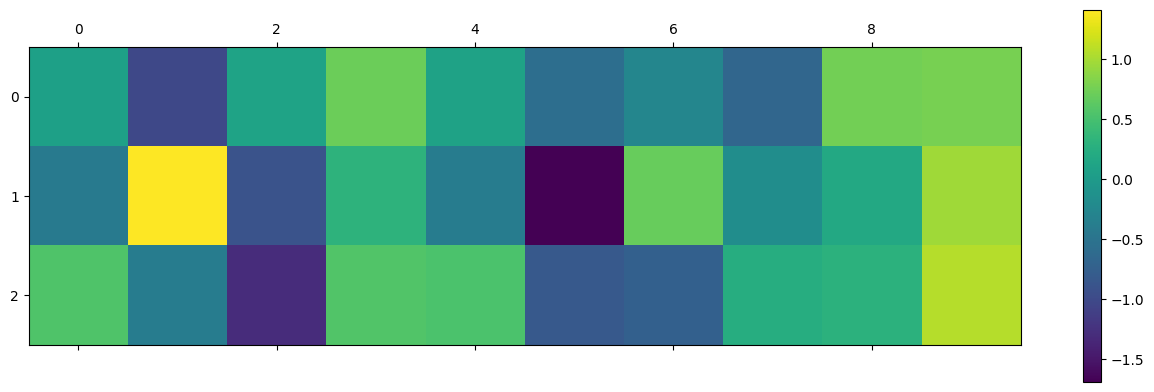

In [48]:
ase_atoms_with_bpcalc = ase.Atoms(atomic_numbers[:10], atom_positions[:10] - atom_positions[:10].T.mean())
ase_atoms_with_bpcalc.calc = backprop_calculator
f1 = jnp.array(ase_atoms_with_bpcalc.get_forces()).T
plt.matshow(f1)
plt.colorbar()
print(ase_atoms_with_calc.get_potential_energy())
f1

In [22]:
# ase_atoms_with_calc = ase.Atoms(atomic_numbers, atom_positions - atom_positions.T.mean())
# ase_atoms_with_calc.calc = calculator
# print(ase_atoms_with_calc.get_potential_energy())

# df["filenames"] = df["key"].apply(lambda x: x.lower() + "_modified.pdb")
# df

# def add_out_pred(fn):
#     fn = data_path / "dcmk" / fn
#     pdb_data_mda = get_data_mda(fn)
#     atomic_numbers, atom_positions = (
#         pdb_data_mda["atomic_numbers"],
#         pdb_data_mda["atom_positions"],
#     )
    
#     ase_atoms_with_bpcalc.set_positions(atom_positions)
#     results = ase_atoms_with_calc.calc.results["out"]
#     return results

# all_output = {k: add_out_pred(k) for k in list(df["filenames"]) }


def plot_forces(results):
    print()
    f1 = jnp.array(results.mm_F).T
    plt.matshow(f1)
    plt.colorbar()
    print()
    f1 = jnp.array(results.internal_F).T
    plt.matshow(f1)
    print(results.energy)
    plt.colorbar()
    
    f1 = jnp.array(results.ml_2b_F).T
    plt.matshow(f1)
    plt.colorbar()
    
    f1 = jnp.array(results.forces).T
    plt.matshow(f1)
    plt.colorbar()

In [23]:
print(ase_atoms_with_calc.get_potential_energy())

Array gpu:0 -33.310




Array gpu:0 -33.310


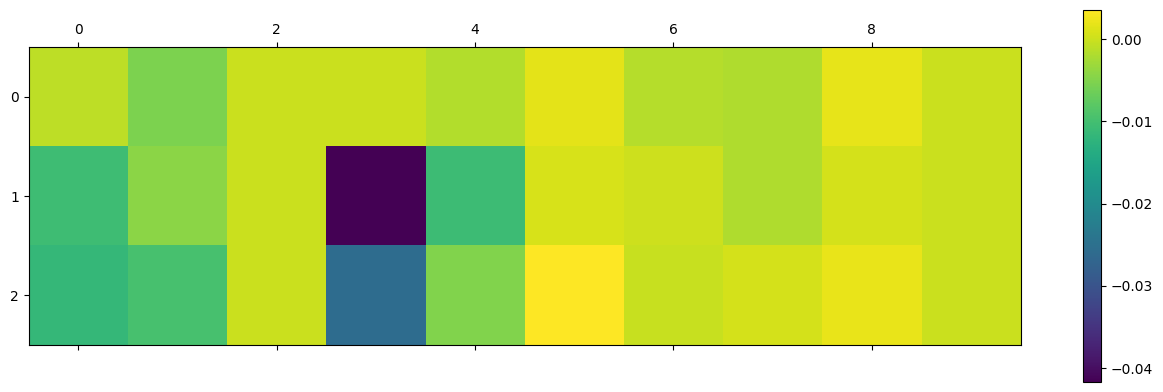

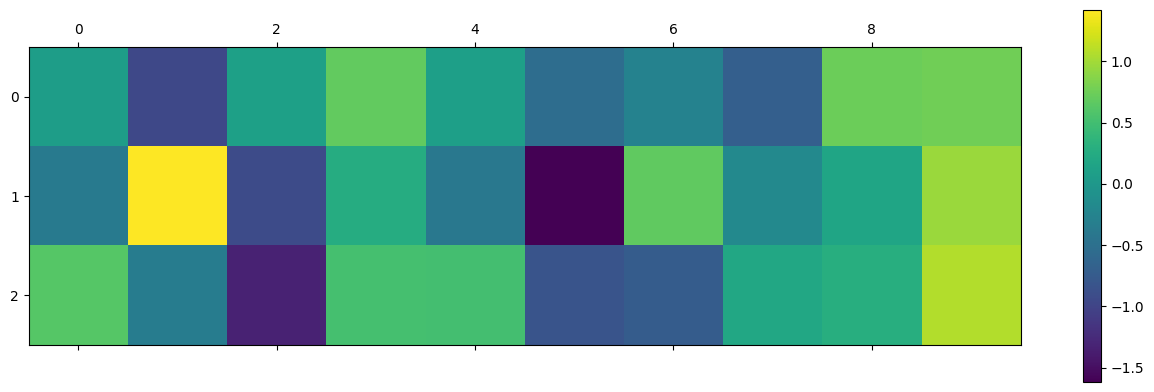

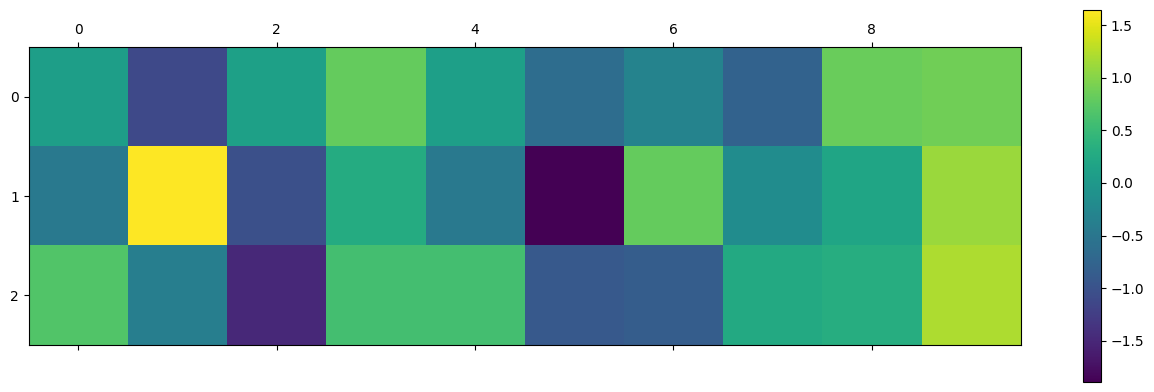

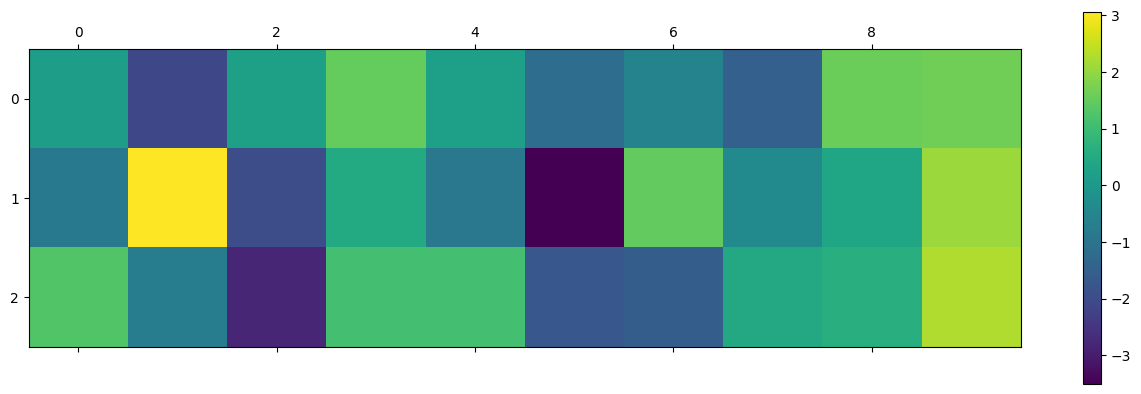

In [25]:
plot_forces(ase_atoms_with_calc.calc.results["out"])

In [26]:
view_atoms(ase_atoms_with_calc)

In [27]:
backprop_calculator.results

{'energy': Array gpu:0 -33.310,
 'forces': Array[10, 3] n=30 x∈[-1.692, 1.412] μ=3.974e-09 σ=0.739 gpu:0}

In [28]:
results = ase_atoms_with_calc.calc.results["out"]
print(results)

ModelOutput(energy=Array gpu:0 -33.310, forces=Array[10, 3] n=30 x∈[-3.509, 3.059] μ=-0.004 σ=1.564 gpu:0, dH=Array gpu:0 0.144, internal_E=Array gpu:0 -33.454, internal_F=Array[10, 3] n=30 x∈[-1.618, 1.420] μ=2.384e-08 σ=0.730 gpu:0, mm_E=Array gpu:0 0.182, mm_F=Array[10, 3] n=30 x∈[-0.042, 0.004] μ=-0.004 σ=0.009 gpu:0, ml_2b_E=Array gpu:0 -0.038, ml_2b_F=Array[10, 3] n=30 x∈[-1.892, 1.643] μ=1.987e-08 σ=0.835 gpu:0)


In [40]:
def add_e_pred(fn):
    fn = data_path / "dcmk" / fn
    pdb_data_mda = get_data_mda(fn)
    atomic_numbers, atom_positions = (
        pdb_data_mda["atomic_numbers"],
        pdb_data_mda["atom_positions"],
    )
    
    ase_atoms_with_bpcalc.set_positions(atom_positions)
    atomic_contribution = Eref[atomic_numbers].sum()
    e_pred = ase_atoms_with_bpcalc.get_potential_energy()
    e_pred = e_pred / ase.units.Hartree + atomic_contribution
    return float(e_pred)

df["cluster_energy_pred"] =  df["filenames"].apply(lambda x: add_e_pred(x))
df

,Cluster,Cluster Energy,Monomer Sum,Formation Energy (Hartree),Formation Energy (kcal/mol),key,filenames,cluster_energy_pred
0,100_LIG_1,-19168.893238,-19168.826734,-0.066504,-41.731854,100_LIG_1,100_lig_1_modified.pdb,-19168.287109
1,100_LIG_10,-19168.874696,-19168.806251,-0.068444,-42.949509,100_LIG_10,100_lig_10_modified.pdb,-19168.326172
2,100_LIG_100,-19168.892131,-19168.828790,-0.063341,-39.747275,100_LIG_100,100_lig_100_modified.pdb,-19168.378906
3,100_LIG_11,-19168.872941,-19168.815802,-0.057139,-35.855129,100_LIG_11,100_lig_11_modified.pdb,-19168.349609
4,100_LIG_12,-19168.871378,-19168.821103,-0.050275,-31.547863,100_LIG_12,100_lig_12_modified.pdb,-19168.341797
...,...,...,...,...,...,...,...,...
95,100_LIG_95,-19168.893409,-19168.829056,-0.064353,-40.382115,100_LIG_95,100_lig_95_modified.pdb,-19168.289062
96,100_LIG_96,-19168.879736,-19168.820661,-0.059075,-37.069863,100_LIG_96,100_lig_96_modified.pdb,-19168.298828
97,100_LIG_97,-19168.887691,-19168.826441,-0.061250,-38.435091,100_LIG_97,100_lig_97_modified.pdb,-19168.294922
98,100_LIG_98,-19168.893152,-19168.828568,-0.064584,-40.527012,100_LIG_98,100_lig_98_modified.pdb,-19168.351562


In [45]:
_ = (df["cluster_energy_pred"] - df["Cluster Energy"])*627.5
_.mean()

356.16189042509416

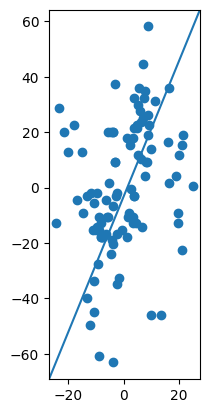

In [42]:
gt_z = (df["Cluster Energy"] - df["Cluster Energy"].mean())*627.5
pred_z =  -(df["cluster_energy_pred"] - df["cluster_energy_pred"].mean())*627.5
plt.scatter(gt_z, pred_z)
ax  = plt.gca()
# ax.transAxes
plt.plot([0,1], [0,1], transform=ax.transAxes)
ax.set_aspect("equal")
# plt.xlim(df["cluster_energy_pred"].min(), df["cluster_energy_pred"].max())
# plt.ylim(df["cluster_energy_pred"].min(), df["cluster_energy_pred"].max())

In [32]:
dimers_data = np.load(Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"))
dimers_data["R"].shape

(20999, 10, 3)

In [47]:
ase_atoms_with_calc.set_positions(dimers_data["R"][0])
ase_atoms_with_calc.get_forces()
results = ase_atoms_with_calc.calc.results["out"]
print(results.forces)
print(results.energy )
print(results)
print(ase_atoms_with_bpcalc.get_forces())
print(ase_atoms_with_bpcalc.get_potential_energy())

Array[10, 3] n=30 x∈[-2.188, 1.983] μ=-0.003 σ=0.646 gpu:0
Array gpu:0 -8.313e+03
ModelOutput(energy=Array gpu:0 -8.313e+03, forces=Array[10, 3] n=30 x∈[-2.188, 1.983] μ=-0.003 σ=0.646 gpu:0, dH=Array gpu:0 -7.999e+03, internal_E=Array gpu:0 -313.638, internal_F=Array[10, 3] n=30 x∈[-1.327, 2.005] μ=-0.002 σ=0.637 gpu:0, mm_E=Array gpu:0 0.224, mm_F=Array[10, 3] n=30 x∈[-0.009, 0.] μ=-0.001 σ=0.002 gpu:0, ml_2b_E=Array gpu:0 -8.000e+03, ml_2b_F=Array[10, 3] n=30 x∈[-2.200, 2.643] μ=1.788e-08 σ=0.949 gpu:0)
Array[10, 3] n=30 x∈[-4.059e+05, 4.876e+05] μ=0.001 σ=1.751e+05 gpu:0
Array gpu:0 -8.313e+03


In [50]:
ase_atoms_with_bpcalc.set_positions(dimers_data["R"][0][[0, 3, 4, 1, 2, 5, 8, 9, 6, 7]])

# results = ase_atoms_with_bpcalc.calc.results["out"]
print(ase_atoms_with_bpcalc.get_forces())
print(ase_atoms_with_bpcalc.get_potential_energy())
# print(results)

Array[10, 3] n=30 x∈[-2.265, 3.503] μ=4.470e-09 σ=1.017 gpu:0
Array gpu:0 -31.776


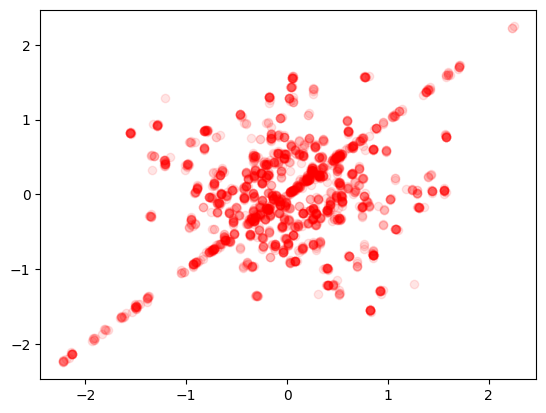

In [67]:
for i in range(100):
    if dimers_data["N"][i] == 10:
        ase_atoms_with_bpcalc.set_positions(dimers_data["R"][i][[0, 3, 4, 1, 2, 5, 8, 9, 6, 7]])
        # ase_atoms_with_calc.set_positions(dimers_data["R"][i][[0, 3, 4, 1, 2, 5, 8, 9, 6, 7]])
        # plt.scatter(jnp.array(dimers_data["F"][i]).flatten(), ase_atoms_with_calc.get_forces().flatten(), color="k", alpha=1)
        plt.scatter(jnp.array(dimers_data["F"][i]).flatten(), ase_atoms_with_bpcalc.get_forces().flatten(), color="r", alpha=0.1)

In [ ]:
for i in range(100):
    ase_atoms_with_bpcalc.set_positions(dimers_data["R"][-1*i][[0, 3, 4, 1, 2, 5, 8, 9, 6, 7]])
    # ase_atoms_with_calc.set_positions(dimers_data["R"][i][[0, 3, 4, 1, 2, 5, 8, 9, 6, 7]])
    # plt.scatter(jnp.array(dimers_data["F"][i]).flatten(), ase_atoms_with_calc.get_forces().flatten(), color="k", alpha=1)
    plt.scatter(jnp.array(dimers_data["F"][i]).flatten(), ase_atoms_with_bpcalc.get_forces().flatten(), color="r", alpha=0.4)

In [22]:
import lovely_jax  as lj
lj.lovely(f1.T, depth=5)

Array[100, 3] n=300 (1.2Kb) x∈[-3.413, 3.421] μ=-0.005 σ=1.181 gpu:0
  Array[3] x∈[-1.415, 2.504] μ=0.452 σ=1.605 gpu:0 [-1.415, 0.268, 2.504]
  Array[3] x∈[-3.108, 3.131] μ=0.378 σ=2.599 gpu:0 [-3.108, 3.131, 1.110]
  Array[3] x∈[-1.334, -0.420] μ=-0.791 σ=0.392 gpu:0 [-1.334, -0.620, -0.420]
  Array[3] x∈[-0.404, 2.396] μ=1.103 σ=1.153 gpu:0 [-0.404, 1.317, 2.396]
  Array[3] x∈[-1.363, 2.513] μ=0.469 σ=1.589 gpu:0 [-1.363, 0.257, 2.513]
  Array[3] x∈[-2.697, -0.670] μ=-1.463 σ=0.884 gpu:0 [-1.022, -2.697, -0.670]
  Array[3] x∈[-0.576, 0.892] μ=-0.077 σ=0.685 gpu:0 [-0.546, 0.892, -0.576]
  Array[3] x∈[-1.490, 0.918] μ=-0.362 σ=0.989 gpu:0 [-1.490, -0.514, 0.918]
  Array[3] x∈[0.010, 1.049] μ=0.685 σ=0.478 gpu:0 [0.996, 0.010, 1.049]
  ...

# Forces

             eps         max(abs(df))
  0.100000000000 Array gpu:0 489.770
  0.010000000000 Array gpu:0 2.324
  0.001000000000 Array gpu:0 3.846
  0.000100000000 Array gpu:0 42.916
  0.000010000000 Array gpu:0 376.301
  0.000001000000 Array gpu:0 3.206e+03
  0.000000100000 Array gpu:0 2.029e+04
  0.000000010000 Array gpu:0 1.541e+05


<Figure size 640x480 with 0 Axes>

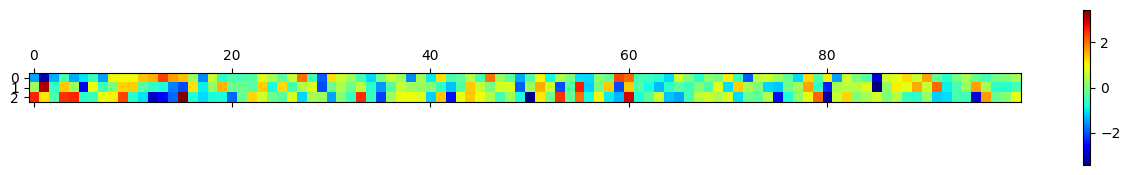

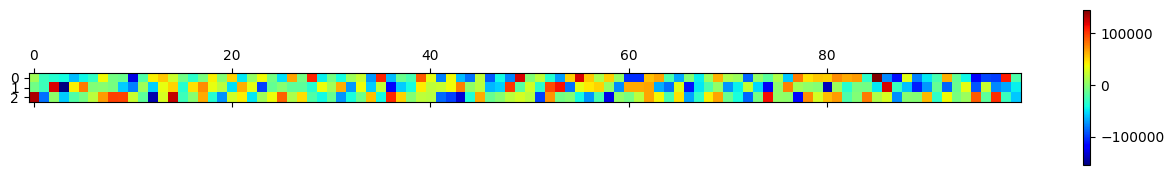

In [23]:
plt.set_cmap('jet')
from ase.calculators.test import gradient_test
f, fn = gradient_test(ase_atoms_with_calc, indices=np.arange(0,100,1))
plt.matshow(np.array(ase_atoms_with_calc.get_forces()).T)
plt.colorbar()
plt.matshow((f - jnp.array(fn)).T)
plt.colorbar()


      Step     Time          Energy          fmax
BFGS:    0 02:36:45     -321.703461        3.191418
BFGS:    1 02:36:45     -323.063263        1.308584
BFGS:    2 02:36:45     -323.755493        1.243593
BFGS:    3 02:36:45     -324.253052        0.870382
BFGS:    4 02:36:45     -324.476196        0.699357
BFGS:    5 02:36:45     -324.633453        0.448628
BFGS:    6 02:36:45     -324.692505        0.287561
BFGS:    7 02:36:45     -324.728058        0.257381
BFGS:    8 02:36:45     -324.763885        0.277725
BFGS:    9 02:36:45     -324.803101        0.335775
BFGS:   10 02:36:45     -324.849976        0.270081
BFGS:   11 02:36:45     -324.891174        0.317665
BFGS:   12 02:36:45     -324.951721        0.335367
BFGS:   13 02:36:45     -325.053436        0.599308
BFGS:   14 02:36:45     -325.236603        0.872346
BFGS:   15 02:36:45     -325.430542        0.823254
BFGS:   16 02:36:46     -325.582825        0.709116
BFGS:   17 02:36:46     -325.712280        0.608687
BFGS:   18 02:

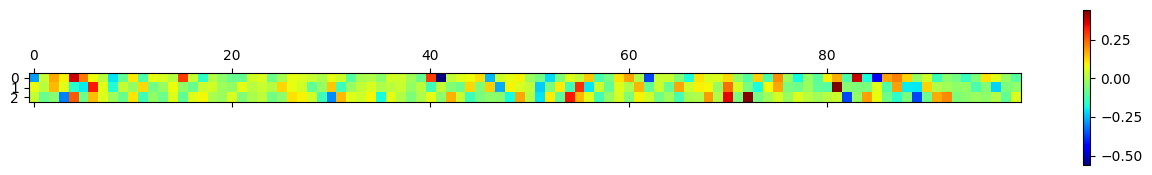

In [24]:
import ase.optimize as ase_opt
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_bpcalc).run(fmax=0.001,steps=20)
plt.matshow(np.array(ase_atoms_with_bpcalc.get_forces()).T)
plt.colorbar()

      Step     Time          Energy          fmax
BFGS:    0 02:36:46     -326.069702        4.910317
BFGS:    1 02:36:46     -325.976349        4.789062
BFGS:    2 02:36:46     -325.536316       15.093683
BFGS:    3 02:36:46     -326.146912       64.536459
BFGS:    4 02:36:46     -483.288879      274.055323
BFGS:    5 02:36:46     -745.456543     1497.956942
BFGS:    6 02:36:46     -768.089478   991713.668096
BFGS:    7 02:36:46     -888.980713   558432.886596
BFGS:    8 02:36:46    -3752.024902 15805171.143810
BFGS:    9 02:36:46    -1050.722046  1483742.078287
BFGS:   10 02:36:46     -822.352478    25256.814684
BFGS:   11 02:36:46    -1586.370239  2563216.513705
BFGS:   12 02:36:46     -705.085022   354383.251252
BFGS:   13 02:36:46    -6206.637695  1879601.860412
BFGS:   14 02:36:46     -515.561646   172412.602788
BFGS:   15 02:36:46    -1255.354370    38221.279099
BFGS:   16 02:36:46    -2036.291382    46333.708507
BFGS:   17 02:36:46    -1301.108887    16070.669930
BFGS:   18 02:

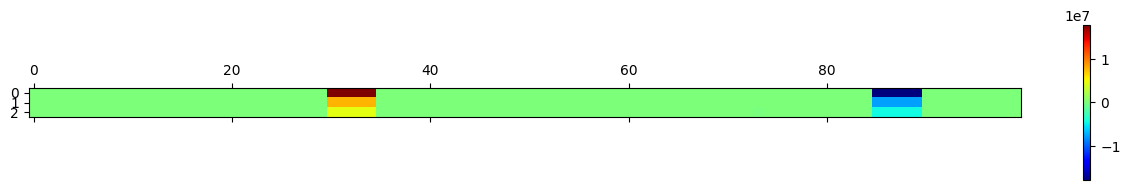

In [25]:
import ase.optimize as ase_opt
ase_atoms_with_calc.set_positions(ase_atoms_with_bpcalc.get_positions())
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_calc).run(fmax=0.001,steps=20)
plt.matshow(np.array(ase_atoms_with_calc.get_forces()).T)
plt.colorbar()

In [26]:
view_atoms(ase_atoms_with_bpcalc)

In [27]:
view_atoms(ase_atoms_with_calc)

In [28]:
# f, jnp.array(fn)
0.1 / 1000

0.0001

In [279]:
# view_atoms(ase_atoms_with_calc)

In [280]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [283]:
# Parameters.
temperature = 200.0
timestep_fs = 0.1
num_steps = 10_000

print(num_steps * timestep_fs / 1000, " ps")

atoms = ase_atoms_with_bpcalc

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 1000 == 0 and temperature <= 300.0:
      temperature += i // 10
      print(temperature)
  if i % 1000 == 0:
      MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
      # Stationary(atoms)  # Remove center of mass translation.
  #     # ZeroRotation(atoms)  # Remove rotations.
  if i % 10 == 0:
      print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

  if jnp.isnan(total_energy[i]) or total_energy[i] > 0:
      break



1.0  ps
200.0
step     0 epot -340.548 ekin  2.763 etot -337.785
step    10 epot -340.417 ekin  2.413 etot -338.005
step    20 epot -340.130 ekin  2.127 etot -338.003
step    30 epot -339.915 ekin  1.914 etot -338.001
step    40 epot -339.835 ekin  1.828 etot -338.007
step    50 epot -339.745 ekin  1.740 etot -338.005
step    60 epot -339.561 ekin  1.556 etot -338.005
step    70 epot -339.357 ekin  1.351 etot -338.006
step    80 epot -339.291 ekin  1.283 etot -338.007
step    90 epot -339.417 ekin  1.417 etot -338.000
step   100 epot -339.635 ekin  1.629 etot -338.006
step   110 epot -339.746 ekin  1.737 etot -338.008
step   120 epot -339.712 ekin  1.702 etot -338.010
step   130 epot -339.670 ekin  1.662 etot -338.008
step   140 epot -339.730 ekin  1.725 etot -338.005
step   150 epot -339.829 ekin  1.824 etot -338.005
step   160 epot -339.841 ekin  1.832 etot -338.009
step   170 epot -339.747 ekin  1.747 etot -338.000
step   180 epot -339.682 ekin  1.682 etot -338.000
step   190 epot -

In [282]:
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# view3d.getModel().setCoordinates(frames[::10], 'array')
# view3d.animate({'loop': None, 'interval': 0.1})
# view3d.show()

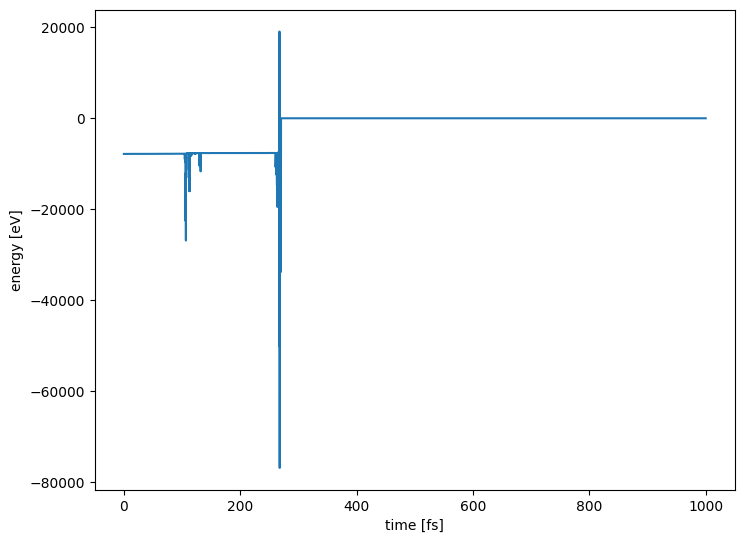

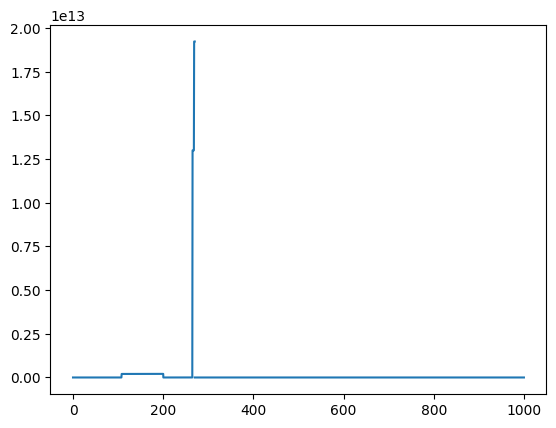

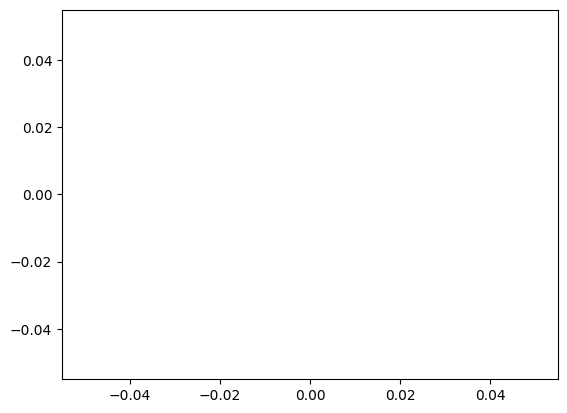

In [254]:
# %matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy/ (ase.units.kcal/ase.units.mol), label='potential energy')
plt.show()
plt.plot(time, kinetic_energy / (ase.units.kcal/ase.units.mol), label='kinetic energy')
plt.show()
te = total_energy / (ase.units.kcal/ase.units.mol)
te -= te.mean()
plt.plot(time[10:100], te[10:100], label='total energy')
plt.show()
# plt.legend()
# plt.grid()

(array([491.,  18.,  49.,  15., 198.,  74.,  13.,  37.,  23.,  72.]),
 array([-1.73801248, -1.15042093, -0.56282937,  0.02476218,  0.61235373,
         1.19994528,  1.78753684,  2.37512839,  2.96271994,  3.5503115 ,
         4.13790305]),
 <BarContainer object of 10 artists>)

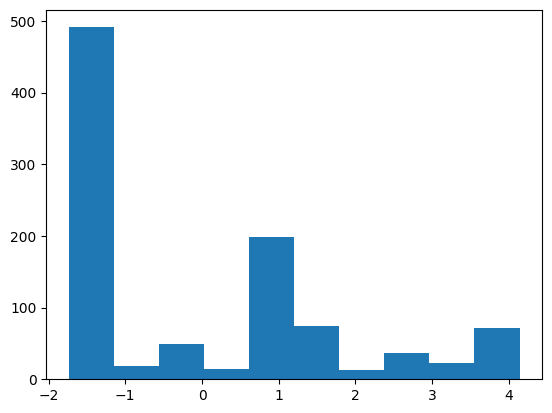

In [255]:
plt.hist(total_energy[10:1000] - total_energy[10:1000].mean())

In [106]:
# partition.neighbor_list?

# JAX MD

In [310]:
from jax_md import partition
from jax_md import space
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax_md
import numpy as np

from ase.io import read
from jax_md import units
from typing import Dict

# from so3lr import to_jax_md
# from so3lr import So3lrPotential

import time


@jit
def jax_md_energy_fn(position, **kwargs):
  l_nbrs = nbrs.update(jnp.array(position))
  return spherical_cutoff_calculator(position, atomic_numbers).energy * (ase.units.kcal/ase.units.mol)



BOXSIZE = 30
displacement, shift = space.periodic(BOXSIZE, wrapped=False)
_, dummy_shift = space.free()
CUTOFF = BOXSIZE/2
neighbor_fn = partition.neighbor_list(displacement, None, CUTOFF, format=partition.Sparse, dtype=jnp.float64)


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5191: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [331]:
# Using float32 for positions / velocities, but float64 for reductions.
# dtype = np.float64
R = ase_atoms_with_calc.get_positions()
# R = np.array(R,)
# print(R)

In [332]:
nbrs = neighbor_fn.allocate(R)

In [333]:
jax_md_grad_fn = jax.grad(jax_md_energy_fn)

jax_md_energy_fn(R)

Array gpu:0 -340.946

In [334]:
jax_md_grad_fn(R)

Array[100, 3] n=300 (1.2Kb) x∈[-0.111, 0.111] μ=-2.018e-07 σ=0.031 gpu:0

In [368]:
from jax_md import minimize

init_fn, step_fn = minimize.fire_descent(jax_md_energy_fn, shift, dt_start=0.001, dt_max=0.001)
unwrapped_init_fn, unwrapped_step_fn = minimize.fire_descent(jax_md_energy_fn, dummy_shift, dt_start=0.1, dt_max=0.1)
unwrapped_step_fn = jit(unwrapped_step_fn)

In [386]:
fire_state = unwrapped_init_fn(R)

positions = []

for i in range(1000):

  positions += [fire_state.position]
  fire_state = jit(unwrapped_step_fn)(fire_state)

  if i % 100 == 0:
      print(i, float(jax_md_energy_fn(fire_state.position)), float(np.abs(np.array(jax_md_grad_fn(fire_state.position))).max()))

0 -340.9495544433594 0.1039876937866211
100 -341.4007873535156 0.04132378101348877
200 -341.7426452636719 0.046424999833106995
300 -341.8677978515625 0.06542706489562988
400 -341.9247131347656 0.01324760913848877
500 -341.9258117675781 0.025714874267578125
600 -341.946533203125 0.026314258575439453
700 -341.97039794921875 0.019542455673217773
800 -341.993408203125 0.06972455978393555
900 -342.1096496582031 0.056350111961364746


In [387]:
(positions[0] - positions[-1]).deeper

Array[100, 3] n=300 (1.2Kb) x∈[-2.038, 1.735] μ=-5.560e-05 σ=0.535 gpu:0
  Array[3] x∈[-0.427, 0.459] μ=0.036 σ=0.363 gpu:0 [0.459, -0.427, 0.076]
  Array[3] x∈[-0.156, 1.029] μ=0.249 σ=0.552 gpu:0 [1.029, -0.156, -0.126]
  Array[3] x∈[-0.411, 0.450] μ=0.024 σ=0.352 gpu:0 [0.450, 0.033, -0.411]
  Array[3] x∈[-0.804, 0.707] μ=0.133 σ=0.668 gpu:0 [0.707, -0.804, 0.496]
  Array[3] x∈[-0.525, 0.083] μ=-0.198 σ=0.250 gpu:0 [-0.152, -0.525, 0.083]
  Array[3] x∈[-0.584, 0.419] μ=-0.104 σ=0.411 gpu:0 [-0.584, 0.419, -0.146]
  Array[3] x∈[-0.690, 0.440] μ=-0.263 σ=0.501 gpu:0 [-0.539, 0.440, -0.690]
  Array[3] x∈[-0.673, 0.602] μ=0.059 σ=0.537 gpu:0 [-0.673, 0.602, 0.248]
  Array[3] x∈[-0.632, 0.619] μ=-0.049 σ=0.515 gpu:0 [-0.632, 0.619, -0.133]
  ...

In [388]:
Z_ = atoms.get_atomic_numbers()
Z_comb = np.concatenate([Z_, Z_])
R_comb = np.stack([positions[0], positions[-1]], axis=0).reshape(200,3)
comb_atoms = ase.Atoms(Z_comb, R_comb)
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, comb_atoms, format='xyz')
# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [389]:
positions = fire_state.position
positions

Array[100, 3] n=300 (1.2Kb) x∈[-14.979, 20.547] μ=5.577e-05 σ=10.007 gpu:0

In [390]:
# unit['temperature']
0.00005 * 1000

0.05

In [469]:

key = random.PRNGKey(0)
dtype = np.float32
# Simulation parameters

timestep = 0.00005  # Time step in ps
nvt_cycles = 20 # Number of Cycles in the NPT.
nvt_steps = 100  # Number of NPT steps per cylce. The total number of MD steps equals npt_cylces * npt_steps

T_init = 1  # Initial temperature.
T_nvt = 300  # Target temperature. 

chain = 3  # Number of chains in the Nose-Hoover chain.
chain_steps = 2  # Number of steps per chain.
sy_steps = 3
thermo = 100 # * unit['temperature'] # Thermo value in the Nose-Hoover chain. 

# Set the temprature at initialization
if T_init is None:
    T_init = T_nvt 
else:
    T_init = T_init

# Dictionary with the NHC settings.
new_nhc_kwargs = {
    'chain_length': chain, 
    'chain_steps': chain_steps, 
    'sy_steps': sy_steps
}

# Convert to metal unit system.
unit = units.metal_unit_system()

timestep = timestep * unit['time']
T_init = T_init * unit['temperature']
T_nvt = T_nvt * unit['temperature']
rng_key = jax.random.PRNGKey(0)

# Some helper functions used throughout the example notebook.

# Default nose hoover chain parameters.
def default_nhc_kwargs(
    tau,
    overrides: Dict
) -> Dict:
    
    default_kwargs = {
        'chain_length': 3, 
        'chain_steps': 2, 
        'sy_steps': 3,
        # 'tau': tau
    }
    
    if overrides is None:
        return default_kwargs
  
    return {
      k: overrides.get(k, default_kwargs[k]) for k in default_kwargs
    }

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:183: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


In [ ]:
partition.neighbor_list?

In [494]:
box = None
displacement, shift = jax_md.space.free()
masses = ase_atoms_with_calc.get_masses()

BOXSIZE = 30
displacement, shift = space.periodic_general(BOXSIZE, wrapped=False)
# _, dummy_shift = space.free()
CUTOFF = BOXSIZE/2
neighbor_fn = partition.neighbor_list(displacement, None, CUTOFF, format=partition.Sparse, dtype=jnp.float64)

# Chosse Nose-Hoover thermostat.
init_fn, apply_fn = jax_md.simulate.nvt_nose_hoover(
    jax_md_energy_fn, 
    shift, 
    dt=timestep, 
    kT=T_init,
    box=box,
    thermostat_kwargs=default_nhc_kwargs(jnp.array(thermo * timestep), new_nhc_kwargs)
)

apply_fn = jax.jit(apply_fn)
init_fn = jax.jit(init_fn)

# Initialize state using position and neigbhors structure relaxation.
state = init_fn(
    rng_key, 
    fire_state.position, 
    neighbor=nbrs.idx, 
    box=box, 
    # neighbor_lr=nbrs_lr.idx,
    kT=T_init,
    mass=masses
)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5191: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [495]:
neighbor_fn = partition.neighbor_list(
    displacement,
    0,
    1,  # load the cutoff of the model from the MLFFPotential
    1,
    1.2,
    1.2,  # as buffer_size_multiplier
    1,
    fractional_coordinates=False,
    format=partition.NeighborListFormat(1),  # only sparse is supported in mlff
    )

neighbor_fn = partition.neighbor_list(displacement, None, CUTOFF*100, format=partition.Sparse)

nbrs = neighbor_fn.allocate(
    fire_state.position,
    # box=box
)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5191: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [496]:
@jax.jit
def step_nvt_fn(i, state):
    
    state, nbrs, box, temp_i = state

    state = apply_fn(
        state, 
        neighbor=nbrs.idx, 
        kT=temp_i,
        box=box
    )
    
    nbrs = nbrs.update(
        fire_state.position, 
        neighbor=nbrs.idx, 
        box = box
    )
    
    return state, nbrs, box, temp_i

In [497]:
T_nvt

Array gpu:0 0.026

In [498]:
# Track total time and step times averaged over cycle.
total_time = time.time()
positions_md = []

for j in range(100):
    
    if j < 100:
        temp_i = T_nvt / ((100 - j) + 1) 
    if j < 4:
        thermo = 100/(j+1) + 50
    print(j, temp_i/ unit['temperature'], T_nvt/ unit['temperature'])
    print('Step\tKE\tPE\tTotal Energy\tTemperature\tH\ttime/steps')
    print('-----------------------------------------------------------------------------------')
    for i in range(nvt_cycles):
        
        # print(temp_i)
        # temp_i = 300 + j * 20 # jnp.asarray(temp_i, dtype=jnp.float64)
        #temp_i *= unit['temperature']
        old_time = time.time()
        # Do `nvt_steps` NVT steps.
        new_state,  nbrs, new_box, temp_i = jax.block_until_ready(
            jax.lax.fori_loop(
                0,
                nvt_steps,
                step_nvt_fn,
                (state,  nbrs, box, temp_i)  # carry state is tuple
            )
        )
        new_time = time.time()
        # Check for overflor of both sr and lr neighbors.
        # if nbrs.did_buffer_overflow:
        #     print('Neighbor list overflowed, reallocating.')
        #     nbrs = neighbor_fn.allocate(state.position, box = box)
        #     # if nbrs_lr.did_buffer_overflow:
        #     #     print('Long-range neighbor list also overflowed, reallocating.')
        #     #     nbrs_lr = neighbor_fn_lr.allocate(state.position, box = box)
        # else:
        state = new_state
        box = new_box
        # Calculate some quantities for printing
        KE = jax_md.quantity.kinetic_energy(
            momentum=state.momentum,
            mass=state.mass
        )
        PE = jax_md_energy_fn(
            state.position,
            neighbor=nbrs.idx,
            # neighbor_lr=nbrs_lr.idx, 
            box=box
        )
        T = jax_md.quantity.temperature(
            momentum=state.momentum,
            mass = state.mass
        ) / unit['temperature']
        H = jax_md.simulate.nvt_nose_hoover_invariant(
            jax_md_energy_fn, 
            state, 
            kT=temp_i,
            neighbor=nbrs.idx,
            # neighbor_lr=nbrs_lr.idx, 
            box=box
        )
        print(f'{i*nvt_steps}\t{float(KE):.2f}\t{float(PE):.2f}\t{float(KE+PE):.3f}\t{float(T):.1f}\t{float(H):.3f}\t{(new_time - old_time) / nvt_steps:.4f}')
        
        if jnp.isnan(KE):
            break

        positions_md.append(np.array(state.position))
    if jnp.isnan(KE):
        break
    
    print('Total_time: ', time.time()-total_time)

0 Array gpu:0 2.970 Array gpu:0 300.000
Step	KE	PE	Total Energy	Temperature	H	time/steps
-----------------------------------------------------------------------------------


AttributeError: 'NoneType' object has no attribute 'size'

In [ ]:
Z_ = atoms.get_atomic_numbers()
Z_comb = np.concatenate([Z_, Z_])
R_comb = np.stack([positions_md[0], positions_md[-1]], axis=0).reshape(200,3)
comb_atoms = ase.Atoms(Z_comb, R_comb)
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, comb_atoms, format='xyz')
# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

In [ ]:
Z_ = atoms.get_atomic_numbers()
Z_comb = np.concatenate([Z_])
R_comb = np.stack([positions_md[-1]], axis=0).reshape(100,3)
comb_atoms = ase.Atoms(Z_comb, R_comb)
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, comb_atoms, format='xyz')
# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

In [ ]:
# Save the frames to xyz.
from ase.io import write
from ase import Atoms
atoms_traj = []


import os
os.remove("nvt_md_trajectory.xyz")

for positions in positions_md:
    atoms_traj.append(
        Atoms(numbers=np.array(atomic_numbers), positions=positions),
    )


for frame in atoms_traj:
    write( 
        'nvt_md_trajectory.xyz',
        frame,
        append=True
    )

In [ ]:
np.linalg.norm(positions_md[-1] - positions_md[0])

In [ ]:
len(atoms_traj)